In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import matplotlib.colors as mpc
import numpy as np
import h5py

import warnings

from activ.viz import get_nmf_labels
from activ.readfile import TrackTBIFile
from activ.nmf.viz import bases_heatmap, bases_factor_order, get_percent_top, plot_bases, plot_weights,\
                          nmfplot, plot_umap_nmf_piechart, plot_umap_nmf_max, plot_umap_nmf_weight, cumulative_plot,\
                          plot_umap_nmf_weight_kde, nmf_bases_plot

import scipy.spatial.distance as spd
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

import itertools as it
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable
from umap import UMAP

/Users/ajtritt/anaconda3/envs/activ/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tbifile_path = 'tracktbi.reg_nmf.h5'
tbifile = TrackTBIFile(tbifile_path)
bm_weights, bm_bases = tbifile.nmf.bm, tbifile.nmf.bm_bases
oc_weights, oc_bases = tbifile.nmf.oc, tbifile.nmf.oc_bases

In [3]:
bm_labels = get_percent_top(tbifile.biomarker_features, bm_bases, perc=0.9)
oc_labels = get_percent_top(tbifile.outcome_features, oc_bases, perc=0.9)

In [4]:
bm_colors = sns.color_palette('Accent', 8)
bm_colors = np.array([bm_colors[i] for i in (6,5,4,2,0)])

oc_colors = sns.color_palette('Set2', 8)
oc_colors = np.array([oc_colors[i] for i in (0, 1, 6, 7, 4, 5, 2, 3)])

In [5]:
bm_emb = UMAP(n_components=2, min_dist=1.0, random_state=20001).fit_transform(tbifile.biomarkers)

binary = list()
continuous = list()
for i in range(tbifile.outcomes.shape[1]):
    # print(tbifile.outcome_features[i], np.unique(tbifile.outcomes[:, i]))
    uniq = np.unique(tbifile.outcomes[:, i])
    if len(uniq) == 2:
        binary.append(i)
    else:
        continuous.append(i)

bindist = spd.pdist(tbifile.outcomes[:, binary], metric='jaccard')
contdist = spd.pdist(tbifile.outcomes[:, continuous], metric='euclidean')

finaldist = (len(binary)*bindist/bindist.max() + len(continuous)*contdist/contdist.max())/tbifile.outcomes.shape[1]

oc_emb = UMAP(n_components=2, min_dist=0.5, random_state=20004, metric='precomputed').fit_transform(spd.squareform(finaldist))

/Users/ajtritt/anaconda3/envs/activ/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [6]:
from io import StringIO

def write_groups_pdf(labels, label_names, path):
    ltx = StringIO()
    pr = lambda x: print(x, file=ltx)


    pr("\documentclass{article}")
    pr("\\usepackage{geometry}")
    pr("\\geometry{a4paper, portrait, left=.75in, right=.75in, top=2in, bottom=2in}")

    pr("\\usepackage{multicol}")
    pr("\\begin{document}")

    for i in range(len(labels)):
        pr('\section{%s}' % label_names[i])
        pr("\\begin{multicols}{2}")
        pr("\\begin{enumerate}")
        for lbl in labels[i]:
            pr("\item %s" % lbl)
        pr("\\end{enumerate}")
        pr("\\end{multicols}")
        pr("\\newpage")

    pr("\end{document}")
    s = ltx.getvalue().replace('_', '\\textunderscore ')
    latex.build_pdf(s).save_to(path)

In [7]:
oc_bases_labels = np.array([
    'Sleep disturbance',
    'Emotional distress', #'Dysphoria and\ndepression', # Depression
    #'6-month\nneurobehavioral\nimpairment', # long-term cognitive deficits
    'Cognitive impairment', #'6-month NBI', # long-term cognitive deficits
    #'3-month\nneurobehavioral\nimpairment', # short-term cognitive deficits
    '3-month NBI', # short-term cognitive deficits
    'Vestibulo-Occular symptoms', #'Dizziness and\nheadache',
    'Conc. and\nep. memory', # Concussive and episodic memory symptoms  # 'Episodic memory',    # verbal learning
    'Functionally Recovered', #'Good outcome',     # Recovered
    'Post-TBI Stress', #'Positive PTSD' # PTSD
])
# write_groups_pdf(oc_labels, oc_bases_labels, 'outcome_nmf_classes-2.pdf')

In [8]:
bm_bases_labels = np.array([
    'Other sociomedical factors', # 'Socioeconomic\nPEMC',    # mild/discharged
    'PEMC', # 'Pre-existing medical conditons', #'Age-related\nPEMC',             # pre-existing health conditions and age
    'PEMHC',  #'Pre-existing mental health conditions', # 'Psychiatric\nPEMC',    # pre-existing psych
    'Intracranial injury', # 'High-severity\nTBI',        # severe injury
#    'GCS and general\nseverity measures'                     # general severity measure
    'Deg. of\nconciousness', # 'Low-severity\nTBI'
])
#nmfplot(bm_weights, bm_bases, axes=axes, bases_labels=bm_bases_labels)
# write_groups_pdf(bm_labels, bm_bases_labels, 'biomarker_nmf_classes.pdf')

In [9]:
bm_bases_labels, oc_bases_labels = get_nmf_labels()

In [10]:
with h5py.File(tbifile_path, 'a') as f:
    TrackTBIFile.write_viz(f, bm_emb=bm_emb, oc_emb=oc_emb, 
                           bm_colors=bm_colors, oc_colors=oc_colors, 
                           bm_labels=bm_bases_labels, oc_labels=oc_bases_labels, overwrite=True)
    TrackTBIFile.write_feat_types(f, 
                                  {'nmf': bm_bases_labels[np.argmax(bm_bases, axis=0)]}, 
                                  {'nmf': oc_bases_labels[np.argmax(oc_bases, axis=0)]}, overwrite=True)

In [11]:
TrackTBIFile.write_feat_types("tracktbi.reg_nmf.h5", 
                              {'nmf': bm_bases_labels[np.argmax(bm_bases, axis=0)]}, 
                              {'nmf': oc_bases_labels[np.argmax(oc_bases, axis=0)]}, overwrite=True)

In [12]:
def get_dom_percs(weights):
    domfac = np.argmax(weights, axis=1)
    dist = np.zeros(weights.shape[1], dtype=int)
    for b in range(weights.shape[1]):
        mask = domfac == b
        dist[b] = mask.sum()
    return dist/dist.sum()

print('outcomes', get_dom_percs(oc_weights))
print('biomarkers', get_dom_percs(bm_weights))

outcomes [0.         0.00404858 0.02834008 0.00809717 0.         0.
 0.8097166  0.14979757]
biomarkers [0.         0.00404858 0.00404858 0.14574899 0.84615385]


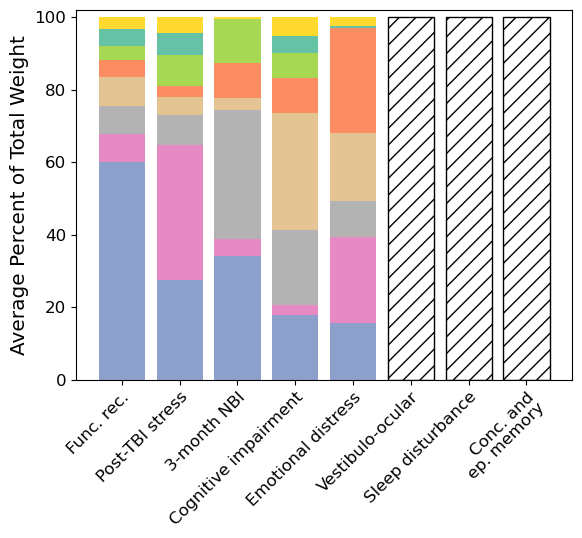

In [13]:

oc_order = plot_weights(oc_weights, oc_colors, ax=plt.gca(), labels=oc_bases_labels, fontsize='x-large', labelsize='large')

/var/folders/78/w3lg7zbx0x1_nfk64y7_350r0000gn/T/ipykernel_30958/3929665919.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig)


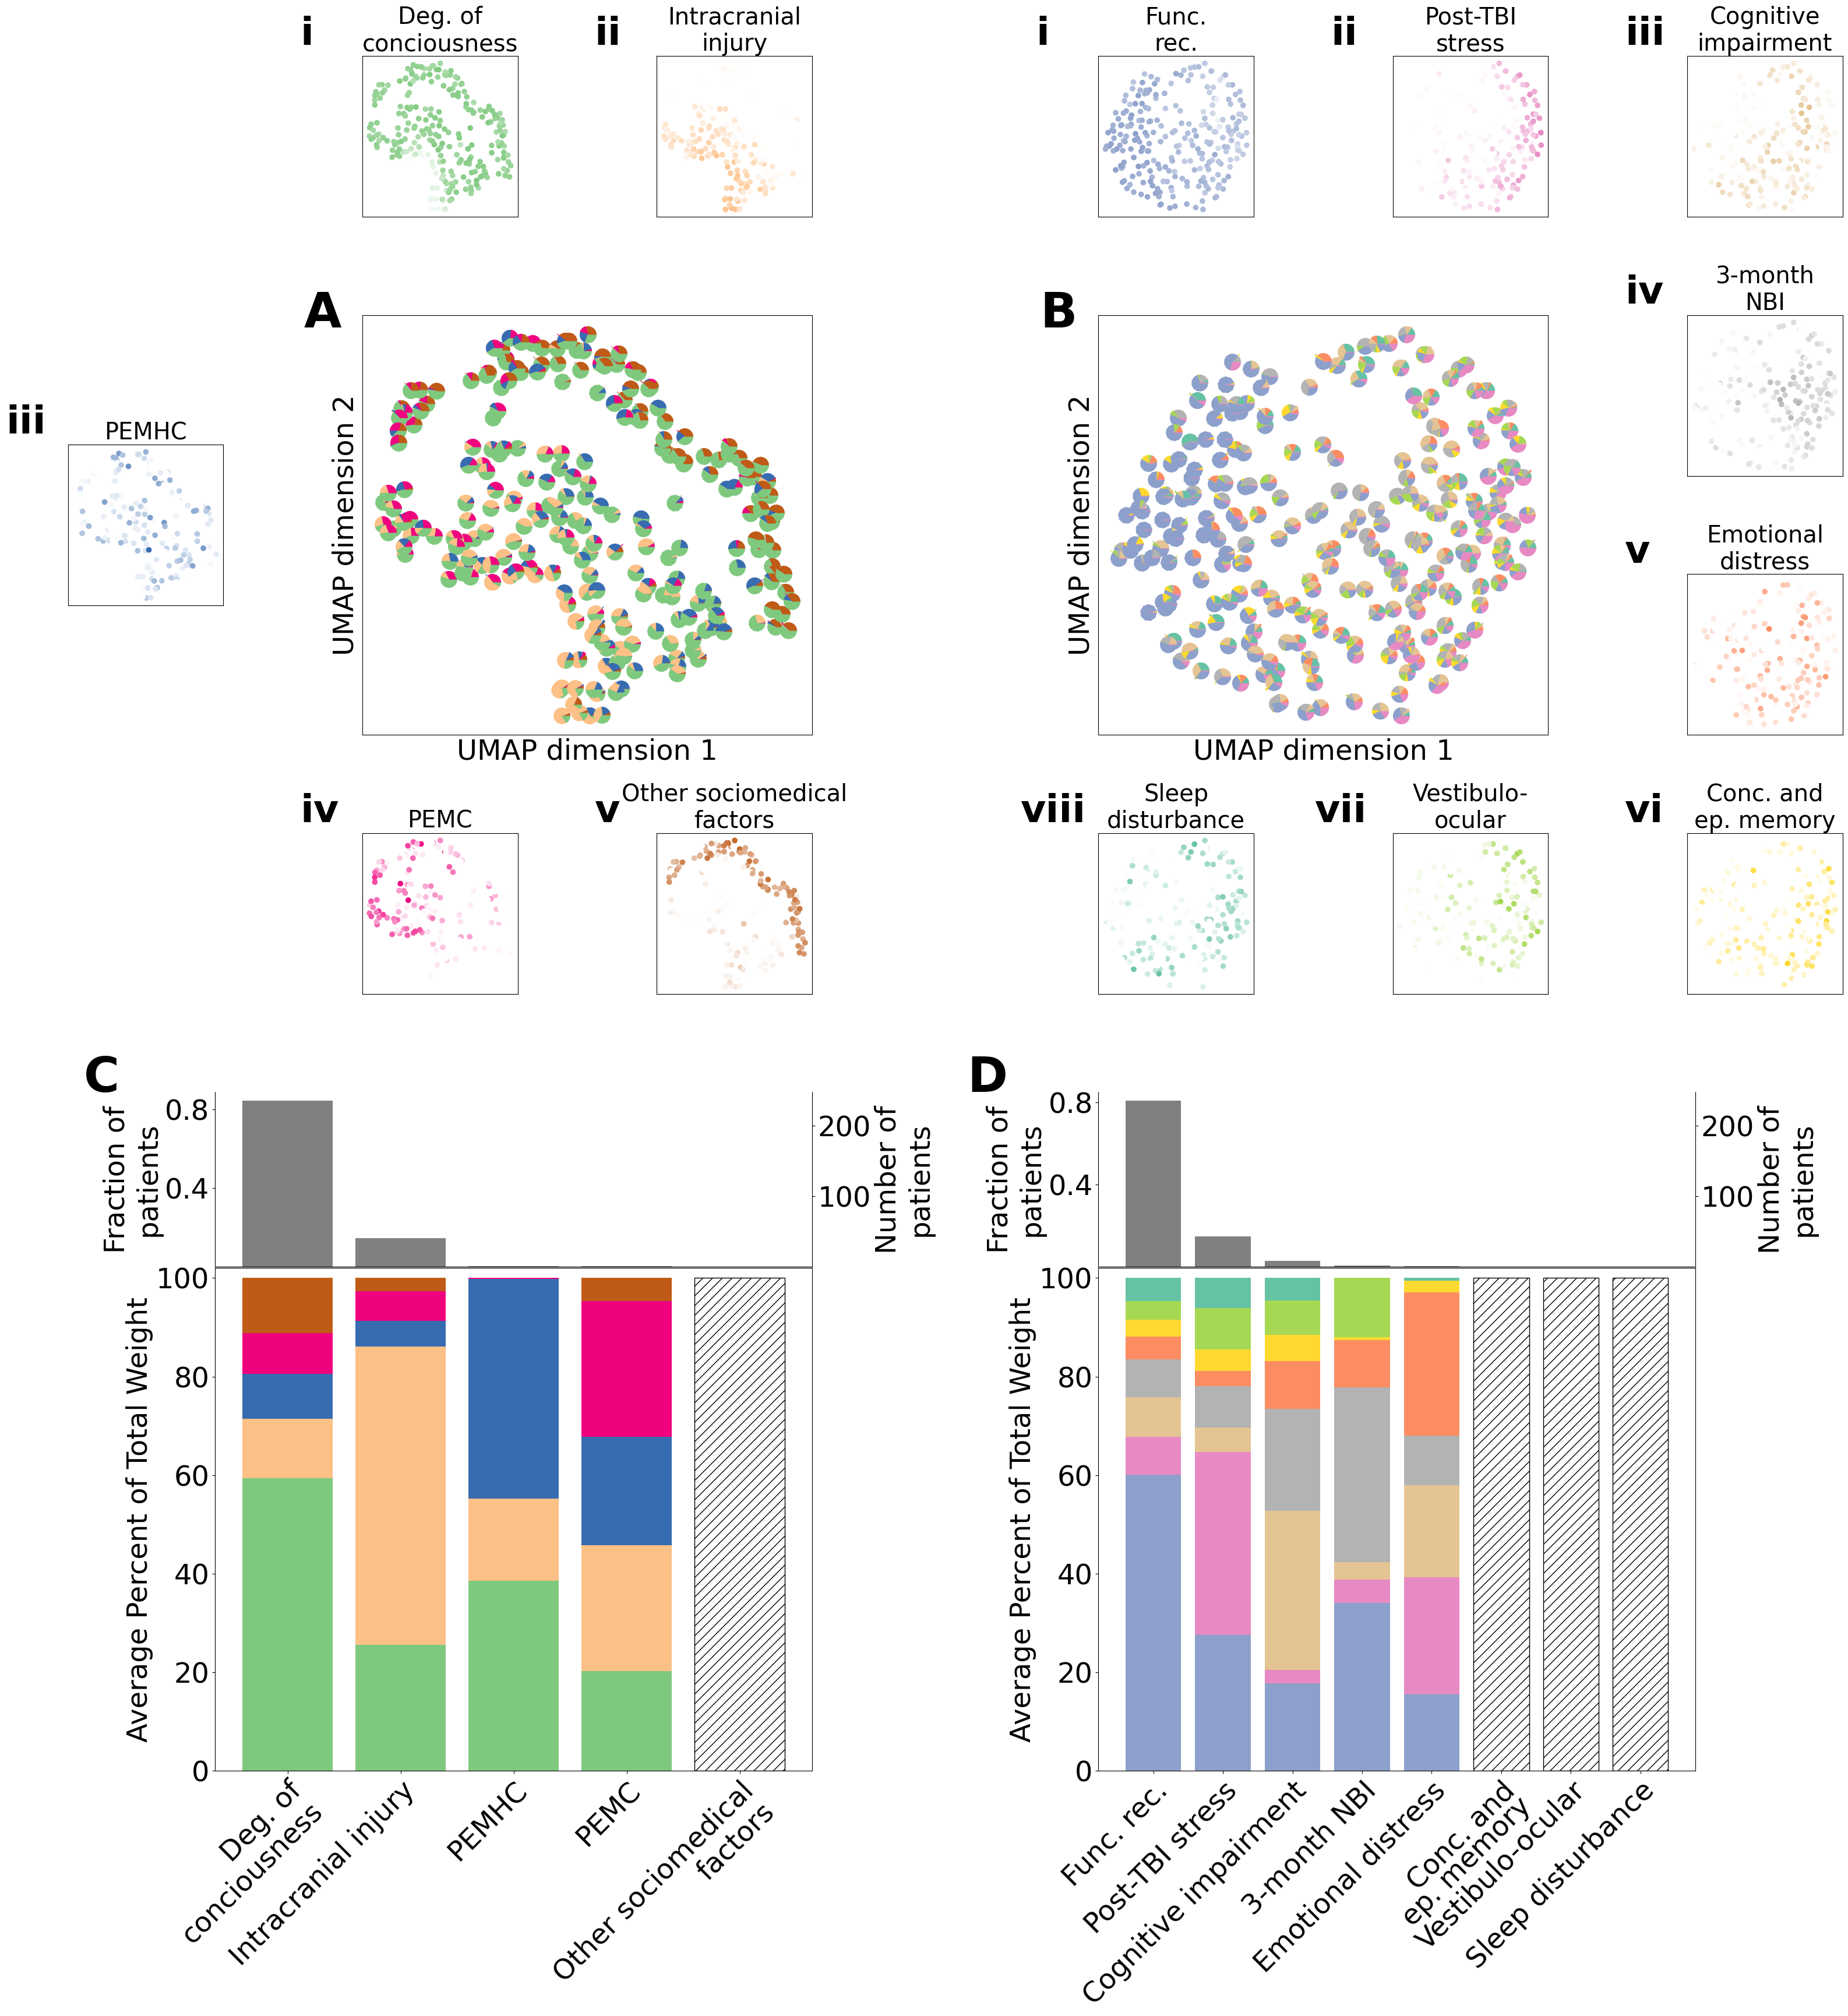

In [14]:
fig = plt.figure(figsize=(32.5, 35))
import matplotlib as mpl
orig_fontsize = mpl.rcParams['font.size']
mpl.rcParams['font.size'] = 20
gs = mgrid.GridSpec(14, 13, figure=fig)

def add_label(ax, label, x=-0.15, y=1.07, size=48):
    te = ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size=size) 

ax_BmWeights = fig.add_subplot(gs[8:, 1:6])
ax_OcWeights = fig.add_subplot(gs[8:, 7:12])
ax_BmBar = make_axes_locatable(ax_BmWeights).append_axes("top", 3.0, pad=0.02, sharex=ax_BmWeights)
ax_OcBar = make_axes_locatable(ax_OcWeights).append_axes("top", 3.0, pad=0.02, sharex=ax_OcWeights)
ax_BmWeights = [ax_BmBar, ax_BmWeights]
ax_OcWeights = [ax_OcBar, ax_OcWeights]


ax_BmMain = fig.add_subplot(gs[2:6, 2:6])
ax_OcMain = fig.add_subplot(gs[2:6, 7:11])

axes = list()
axes.append(fig.add_subplot(gs[0:2, 2:4]))
axes.append(fig.add_subplot(gs[0:2, 4:6]))
axes.append(fig.add_subplot(gs[3:5, :2]))
axes.append(fig.add_subplot(gs[6:8, 2:4]))
axes.append(fig.add_subplot(gs[6:8, 4:6]))

axes.append(fig.add_subplot(gs[0:2, 7:9]))
axes.append(fig.add_subplot(gs[0:2, 9:11]))
axes.append(fig.add_subplot(gs[0:2, 11:]))
axes.append(fig.add_subplot(gs[2:4, 11:]))
axes.append(fig.add_subplot(gs[4:6, 11:]))
axes.append(fig.add_subplot(gs[6:8, 11:]))
axes.append(fig.add_subplot(gs[6:8, 9:11]))
axes.append(fig.add_subplot(gs[6:8, 7:9]))


sckw = {'s':64}

for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v'), axes[:5]):
    add_label(ax, lbl, x=-0.4, y=1.07)
    
for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v', 'vi'), axes[5:-2]):
    add_label(ax, lbl, x=-0.4, y=1.07)
  
for lbl, ax in zip(('vii', 'viii'), axes[-2:]):
    add_label(ax, lbl, x=-0.5, y=1.07)


def swap_newline(labels):
    labels = labels.copy()
    for i in range(len(labels)):
        if '\n' in labels[i]:
            continue
        labels[i] = labels[i].replace(' ', '\n')
    return labels

bm_labels = swap_newline(bm_bases_labels)
oc_labels = swap_newline(oc_bases_labels)
oc_labels[4] = oc_labels[4].replace('-', '-\n')

factor_order = lambda W: np.argsort(np.bincount(np.argmax(W, axis=1), minlength=W.shape[1]))[::-1]

pwkwargs = dict(fontsize='xx-large', labelsize='xx-large')
bm_order = plot_weights(bm_weights, bm_colors, ax=ax_BmWeights, labels=bm_bases_labels, factor_order=factor_order(bm_weights), **pwkwargs, linespacing=1.1)
oc_order = plot_weights(oc_weights, oc_colors, ax=ax_OcWeights, labels=oc_bases_labels, factor_order=factor_order(oc_weights), **pwkwargs, linespacing=0.75)

plot_umap_nmf_weight(bm_emb, bm_weights[:, bm_order], axes[:5], bm_labels[bm_order], [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in bm_colors[bm_order]], cbar=False)
plot_umap_nmf_weight(oc_emb, oc_weights[:, oc_order], axes[5:], oc_labels[oc_order], [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in oc_colors[oc_order]], cbar=False)


for _ax in (ax_BmMain, ax_OcMain):
    _ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    _ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    _ax.title.set_in_layout(False)

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=400, ax=ax_BmMain, fontsize='xx-large', palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=400, ax=ax_OcMain, fontsize='xx-large', palette=oc_colors)

ax_BmWeights = ax_BmWeights[1]
ax_OcWeights = ax_OcWeights[1]

for lbl, ax in zip('AB', (ax_BmMain, ax_OcMain)):
    add_label(ax, lbl, x=-0.13, y=0.97, size=60)

for lbl, ax in zip('CD', (ax_BmBar, ax_OcBar)):
    add_label(ax, lbl, x=-0.22, y=1.0, size=60)
    
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_in_layout(False)
    ax.yaxis.set_in_layout(False)

    ax.xaxis.label.set_in_layout(False)
    ax.yaxis.label.set_in_layout(False)


gs.tight_layout(fig)
plt.savefig('../../paper/umap_piecharts_scatter.weights.png', dpi=200)
plt.savefig('../../paper/umap_piecharts_scatter.weights.svg', dpi=200)
#mpl.rcParams['font.size'] = orig_fontsize

/Users/ajtritt/projects/activ/mmda.git/activ/nmf/viz.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(row_labels, fontsize=fontsize)


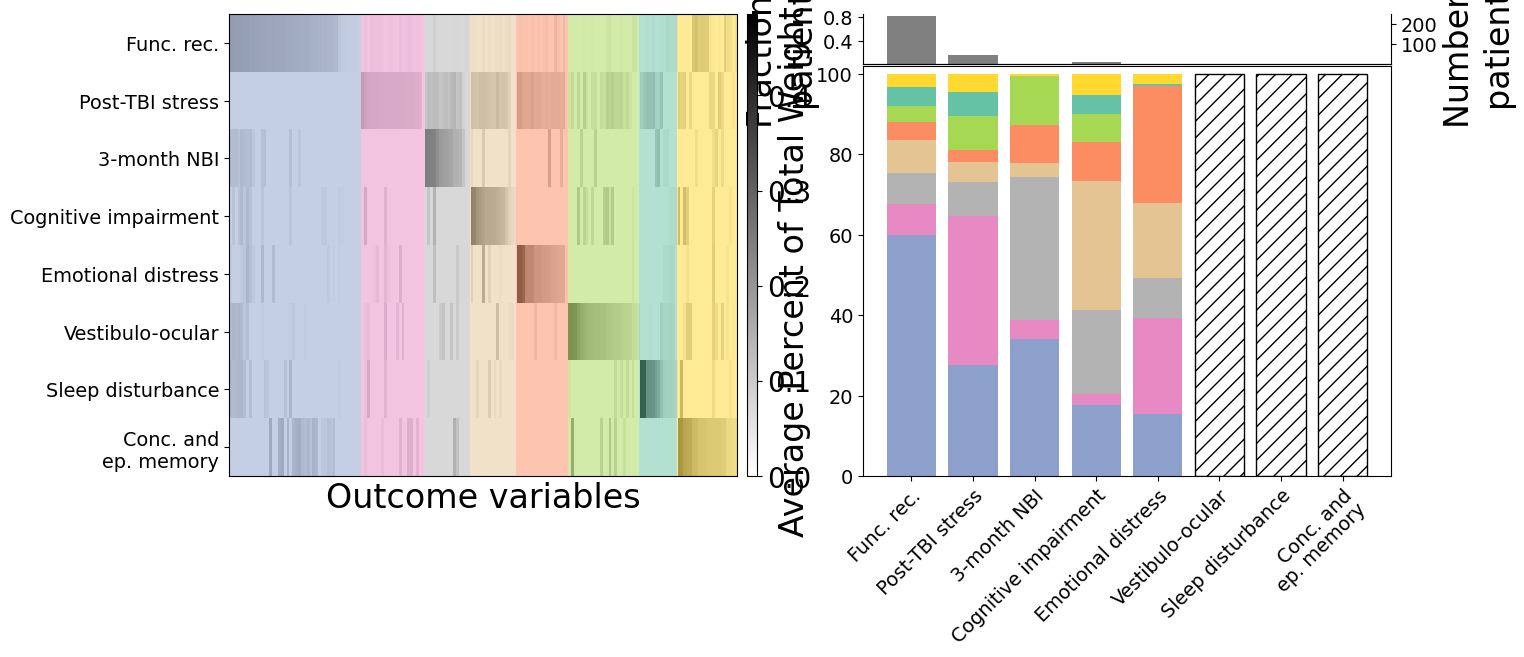

In [15]:
"""
TODO: Add horizontal lines to demarcate factors in heatmaps

"""
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax_hm = axes[0]
ax_bp = axes[1]
ax_bp2 = make_axes_locatable(ax_bp).append_axes("top", 0.5, pad=0.02, sharex=ax_bp)
axes = [ax_hm, ax_bp2, ax_bp]
factor_order = nmfplot(oc_weights, oc_bases, axes=axes, bases_order=False, bases_labels=oc_bases_labels, 
                       fontsize='large', heatmap_xlabel="Outcome variables", labelsize='x-small', palette=oc_colors)

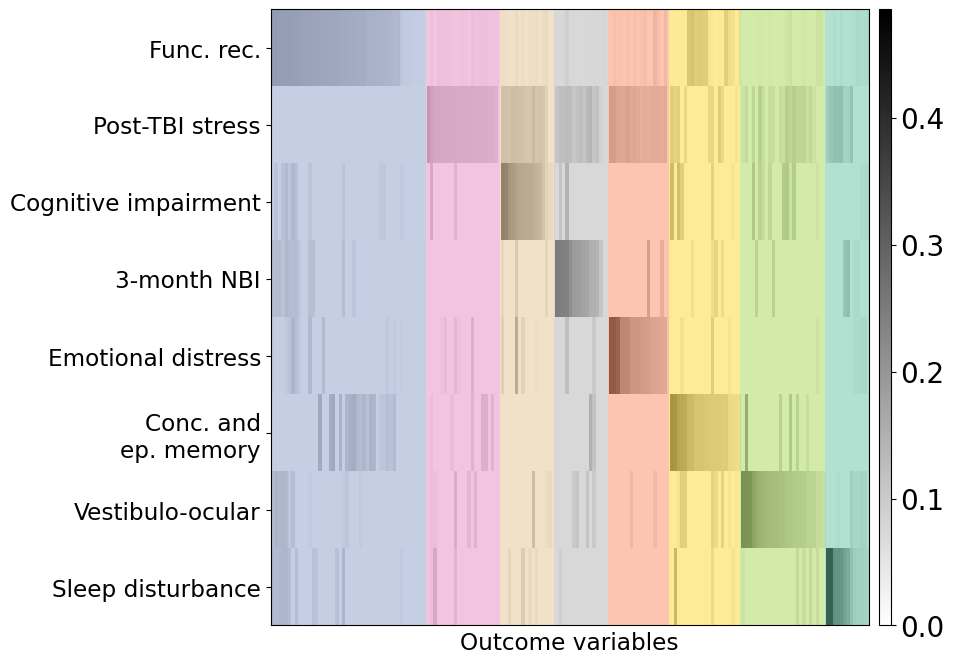

In [16]:
plt.figure(figsize=(8,8))
factor_order = plot_bases(oc_bases, oc_colors, feat_names=False, ax=plt.gca(), bases_labels=oc_bases_labels, 
                       fontsize='small', xlabel="Outcome variables", factor_order=oc_order)

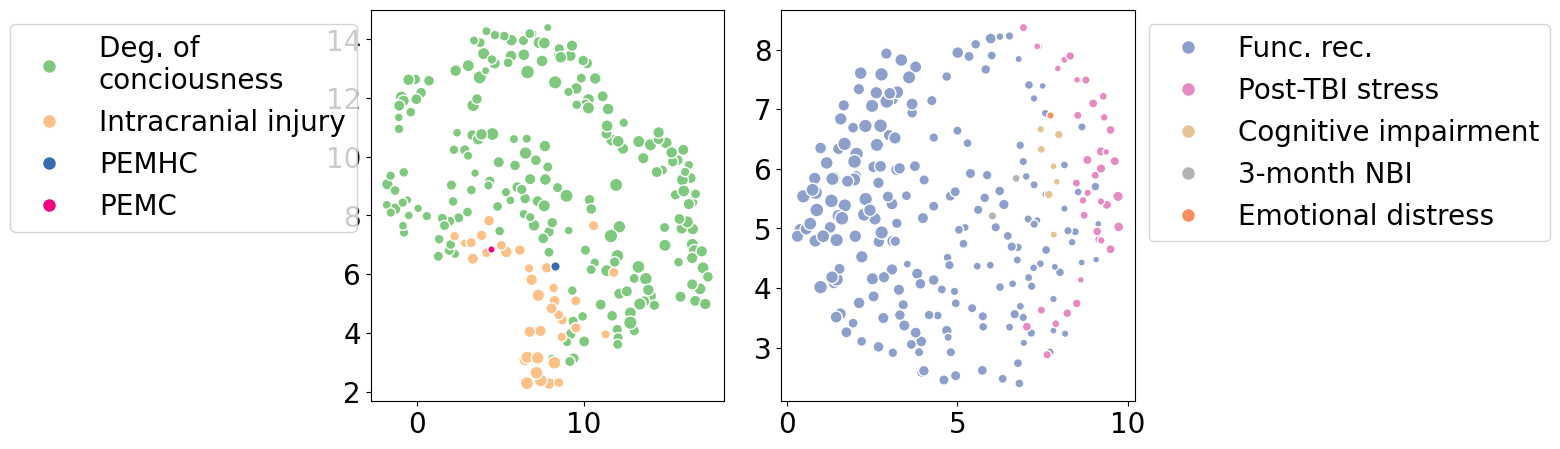

In [17]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plot_umap_nmf_max(bm_emb, bm_weights, bm_bases_labels, min_dist=1.0, palette=bm_colors)
plt.subplot(1,2,2)
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)
plt.tight_layout()
plt.savefig("nmf_labelled_umap.png", dpi=200)

In [18]:
varmap = {
    "admGCSmotor.t": "ED GCS motor (recode)",
    "admGCSmotor": "ED GCS motor",
    "admGCSeyes.t": "ED GCS eyes (recode)",
    "admGCSeyes": "ED GCS eyes",
    "admGCS": "ED GCS",
    "EDArrRespRateType": "ED respiration rate type",
    "MRIDone": "2 week MRI completed Y/N",
    "ISS_Score_MoreThan15": "Major trauma",
    "AIS_HeadNeckMoreThan2": "Significant head trauma",
    "Injurytype_Closed": "Blunt trauma",
    "PatientTypeCoded_ICU.Admit": "Admitted to ICU",
    "PatientTypeCoded_ED.Discharge": "Discharged from ED",
    "MEDS_Anticoagulants": "Hist. anticoagulation use",
    "PMH_Cardiac_Other": "PMH cardiac disease",
    "SHX_Alcohol": "Hist. alcohol use",
    "SHX_Tobacco": "Hist. tobacco use",
    "SHX_IllicitDrugs": "Hist. illicit drug use",
    "PMH_Cardiac_HTN": "PMH hypertension",
    "CT_Intracraniallesion_FIN": "CT pos. intracranial injury",
    "PMH_Psych_Depression": "PMH depression",
    "PMH_Psych_ANY": "PMH psychiatric disease",
    "PMH_Cardiac_ANY": "PMH cardiac disease",
    "Age": "Patient age",
    "DispER_Discharge.Home": "Discharged to home",
    "injurytype_Closed": "closed/blunt TBI",
    "CT_SAH_FIN": "CT pos. subarachnoid hemorrhage",
    

#    "NeuroWorsenCognitiveActivity6mo": "Symptoms worsen with cognitive activity, at 6m",
    "NeuroWorsenCognitiveActivity6mo": "Sym. worse. w/ cog. act., at 6m",
    "NeuroEmotionalMoreEmotional6mo": "Feeling more emotional, at 6m",
    "NeuroEmotionalSadness6mo": "Sadness, at 6m",
    "NeuroEmotionalIrritability6mo": "Irritability, at 6m",
    "NeuroCognitiveDiffRemembering6mo": "Difficulty remembering, at 6m",
    "NeuroCognitiveDiffConcentrating6mo": "Difficulty concentrating, at 6m",
    "NeuroCognitiveFoggy6mo": "Feeling foggy, at 6m",
    "NeuroSleepTroubleFallingAsleep6mo": "Trouble falling asleep, at 6m",
    "CHARTSFCognitiveTotal_6mo": "CHARTSF Cognitive, at 6m",
    "GOSE_Travel6M": "GOSE Travel, at 6m",
    "RPQBlurredVision_6mo_R": "Blurred vision, at 6m",
    "NeuroCognitiveDiffRemembering3mo": "Difficulty remembering, at 3m",
    "NeuroCognitiveSlowedDown3mo": "Feeling slowed down, at 3m",
    "NeuroCognitiveFoggy3mo": "Feeling foggy, at 3m",
    "PTSD_6mo": "PTSD, by DSM-IV crit., at 6m",
    "RPQBlurredVision_6mo": "Blurred vision, at 6m",
    "RPQSleepDisturbance_6mo": "Sleep disturbance, at 6m",
    "CHARTSFInHomeAssistTime_6mo": "CHARTSF In-Home Assistance, at 6m",
    "NeuroPhysLightSensitivity6mo": "Light sensitivity, at 6m",
    "NeuroSleepDrowsiness6mo": "Drowsiness, at 6m",
    "NeuroPhysVisualProbl6mo": "Visual problems, at 6m",
    "NeuroPhysBalanceProbl6mo": "Balance problems, at 6m",
    "NeuroSleepSleepingLess6mo": "Sleeping less than usual, at 6m",
    "RPQBlurredVision_6mo": "Blurred vision, at 6m",
    "RPQBlurredVision_6mo_R": "Blurred vision (adj. score), at 6m",
}







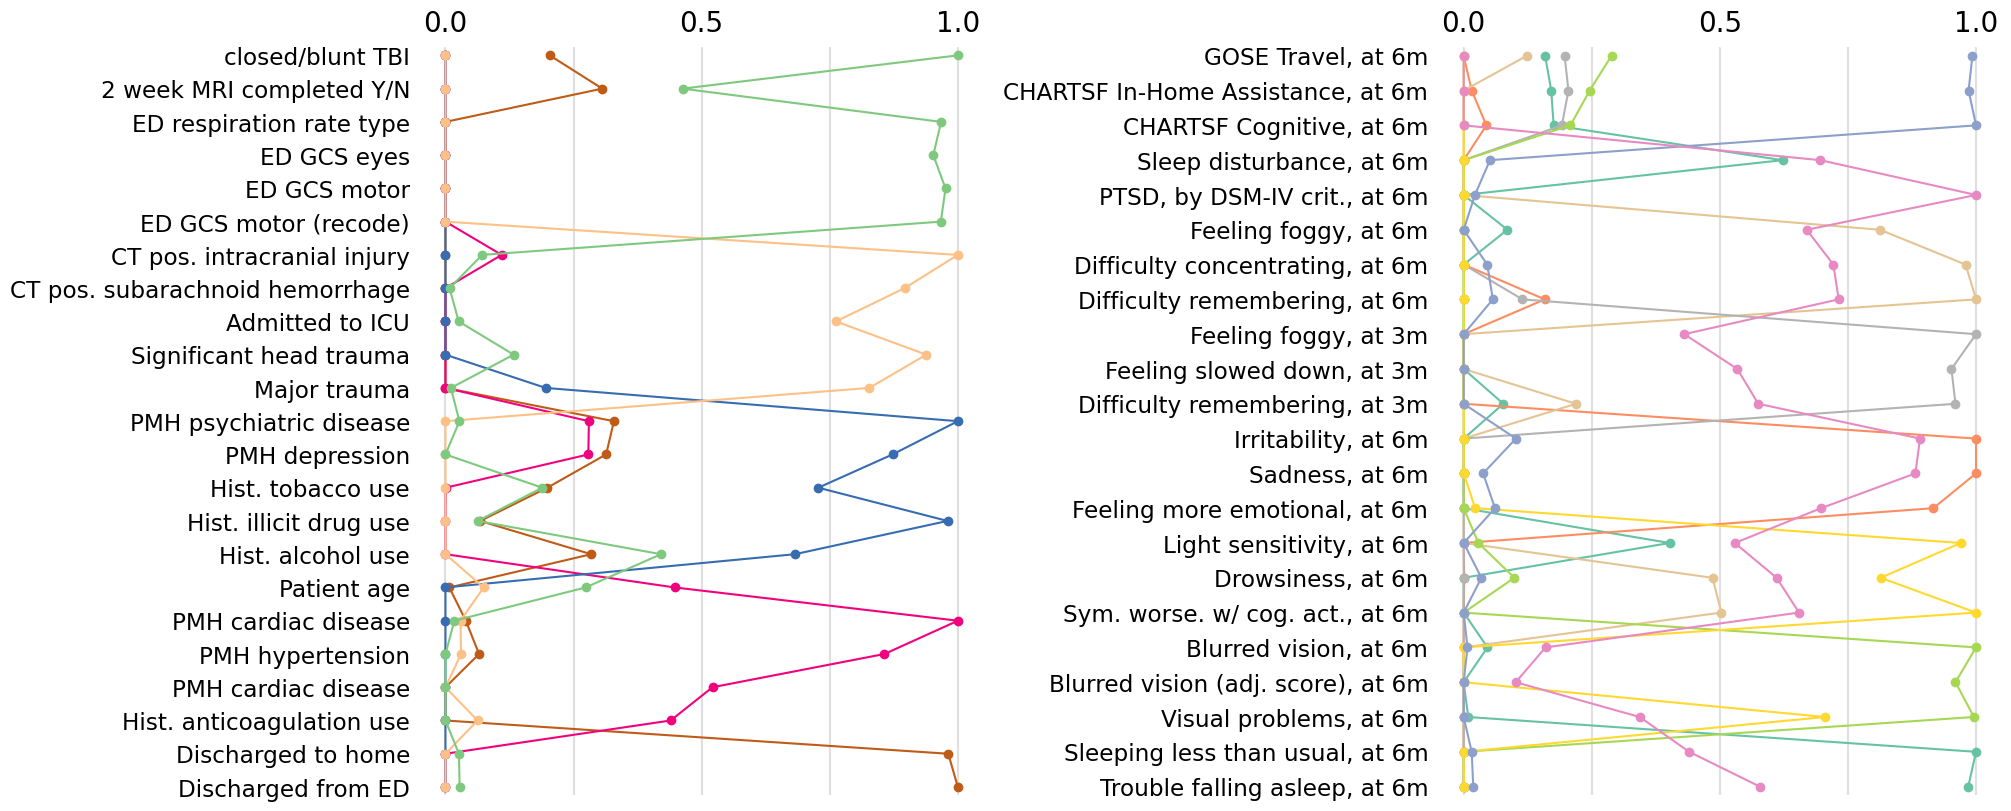

In [19]:
def vert_scatter(bases, labels, colors, ax=None, max_features=None, topk=5, labelsize='small', order=None):
    """
    TODO: Order so that features are grouped by latent factors. Scatter lines 
    """
    
    if ax is None:
        ax = plt.gca()
    
    bases = (bases.T / bases.max(axis=1)).T
    
    indices = bases.argsort(axis=1)[:, -topk:][:, ::-1]
    uniq = set()
    for i in range(topk):
        uniq.update(set(indices[:, i].tolist()))
        if max_features is not None and len(uniq) > max_features:
            break
    indices = np.array(list(uniq))
    
    bases = bases[:, indices]
    labels = labels[indices]
    
    if order is None:
        order = np.arange(bases.shape[0])
    
    argmax = np.argmax(bases, axis=0)
        
    disp_order = list()
    for idx in order:
        disp_order.append(np.where(argmax == idx)[0])
    disp_order = np.concatenate(disp_order)[::-1]
    
    bases = bases[:, disp_order]
    labels = labels[disp_order]
    
    n_feat = 10
    for i in range(len(bases)):
        y = bases[i]#[indices]
        ax.plot(y, np.arange(len(y)), marker='o', color=colors[i])
    ###################### 
    
    labels = [varmap.get(l, f'>{l}<') for l in labels]
        
    ret = ax.set_yticks(np.arange(len(indices)), labels=labels, fontsize=labelsize)

    ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True, color='white')
    ax.tick_params(axis="y", color='white')

    ax.set_ylim(-0.25, len(indices)-1 +0.25)
    xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
    for i in xticks:
        ax.axvline(i, color='gray', alpha=0.25, zorder=0)
    ax.set_xticks(xticks[::2], labels=['0.0', '0.5', '1.0'])
        
    for k in ax.spines:
        ax.spines[k].set_visible(False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
vert_scatter(bm_bases, tbifile.biomarker_features, bm_colors, ax=axes[0], order=bm_order, topk=5, max_features=20)
vert_scatter(oc_bases, tbifile.outcome_features, oc_colors, ax=axes[1], order=oc_order, topk=5, max_features=20)

# multi-panel figure 
- a, b, c - bm barplot, bm heatmap, bm umap-pie-chart
- d, e, f - oc barplot, oc heatmap, oc umap-pie-chart

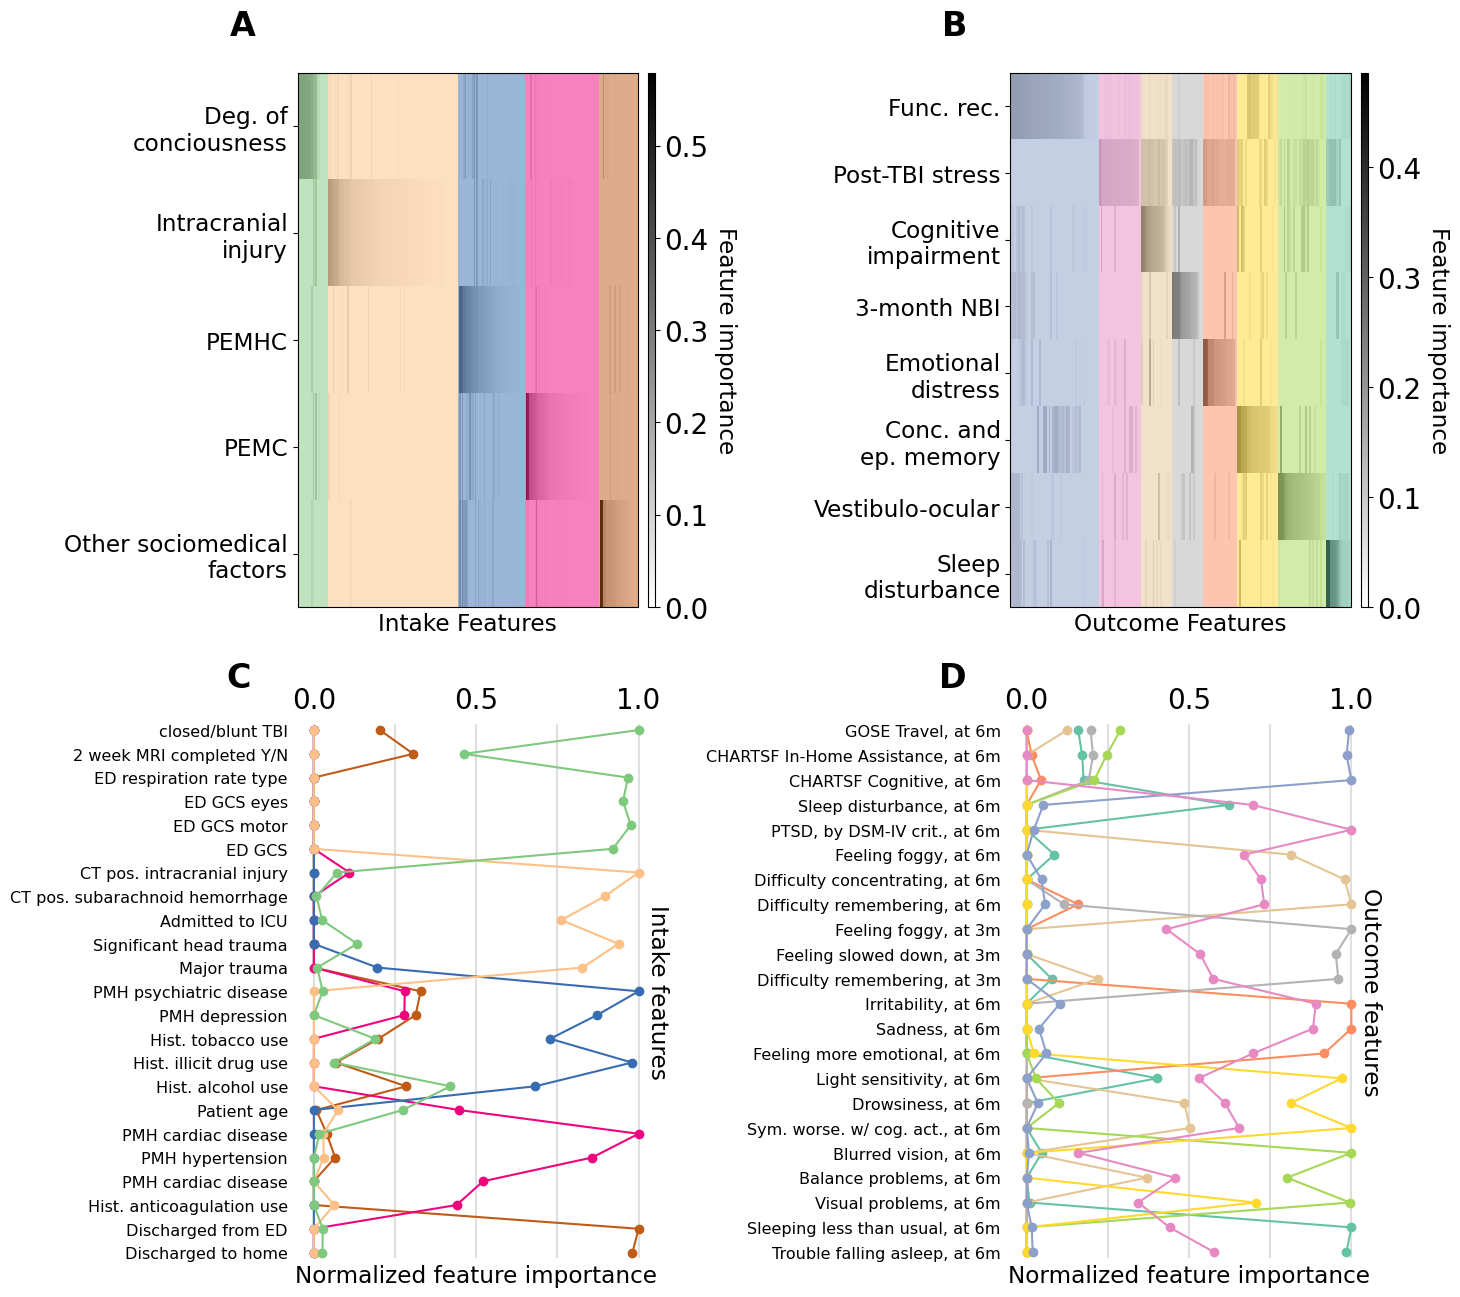

In [20]:
def add_label(ax, label, x=-0.1, y=1.07, size='xx-large'):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size=size)    
#################################################

fig_width = 15
fig_height = 13.33

fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

axA = axes[0, 0]
axC = axes[1 ,0]
axB = axes[0, 1]
axD = axes[1, 1]


fs = 'x-large'
ls = 'large'

def swap_newline(labels, *item):
    labels = labels.copy()
    for i in item:
        labels[i] = labels[i].replace(' ', '\n')
    return labels

oc_labels = swap_newline(oc_bases_labels, *oc_order[[2,4,7]])
bm_labels = swap_newline(bm_bases_labels, *bm_order[[1]])


plot_bases(bm_bases, bm_colors, feat_names=False, ax=axA, bases_labels=bm_labels, 
                       fontsize='small', xlabel="Intake Features", factor_order=bm_order, cbarlabel='Feature importance')
plot_bases(oc_bases, oc_colors, feat_names=False, ax=axB, bases_labels=oc_labels, 
                       fontsize='small', xlabel="Outcome Features", factor_order=oc_order, cbarlabel='Feature importance')

fig.canvas.draw()

def remove_features(bases, features, *exclude):
    mask = np.ones(features.shape[0], dtype=bool)
    for ex in exclude:
        mask[features == ex] = False
    return bases[:, mask], features[mask]

_bm_bases, _bm_features = remove_features(bm_bases, tbifile.biomarker_features, 'admGCSmotor.t', 'admGCSeyes.t', 'admGCSverb.t')
_oc_bases, _oc_features = remove_features(oc_bases, tbifile.outcome_features, 'RPQBlurredVision_6mo_R')

vert_scatter(_bm_bases, _bm_features, bm_colors, ax=axC, labelsize='xx-small', order=bm_order, topk=5, max_features=20)
axC.set_ylabel("Intake features", fontsize='small', rotation=270)
axC.yaxis.set_label_position("right")
axC.yaxis.set_label_coords(1.04,0.5)
axC.set_xlabel("Normalized feature importance", fontsize='small')
vert_scatter(_oc_bases, _oc_features, oc_colors, ax=axD, labelsize='xx-small', order=oc_order, topk=5, max_features=20)
axD.set_ylabel("Outcome features", fontsize='small', rotation=270)
axD.yaxis.set_label_position("right")
axD.yaxis.set_label_coords(1.04,0.5)
axD.set_xlabel("Normalized feature importance", fontsize='small')

for ax, lbl in zip([axA, axB, axC, axD] , "ABCD"):
    add_label(ax, lbl, x=-0.2, size='large')



fig_path = '../../paper/MultiPanel_latent_features_NMF.scatter.png'
svg_path = '../../paper/MultiPanel_latent_features_NMF.scatter.svg'
fig_dpi = 200
plt.tight_layout()
plt.savefig(fig_path, dpi=fig_dpi)
plt.savefig(svg_path, dpi=fig_dpi)

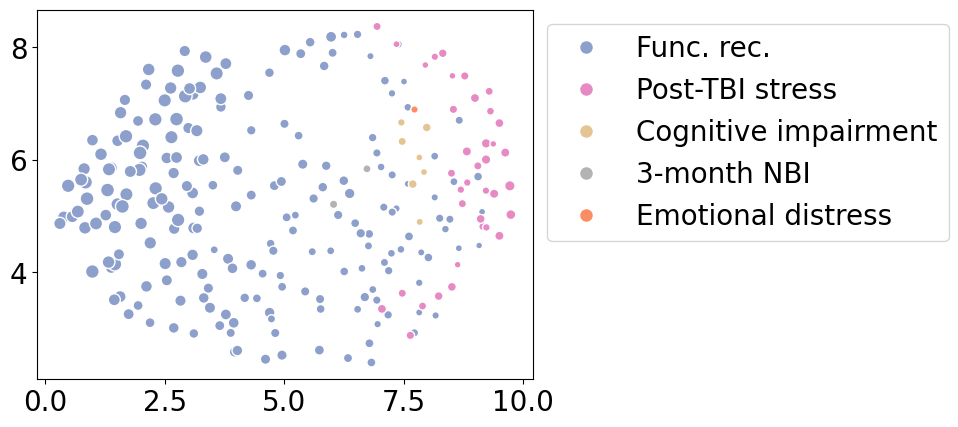

In [21]:
plot_umap_nmf_max(oc_emb, oc_weights, oc_bases_labels, right=True, palette=oc_colors)

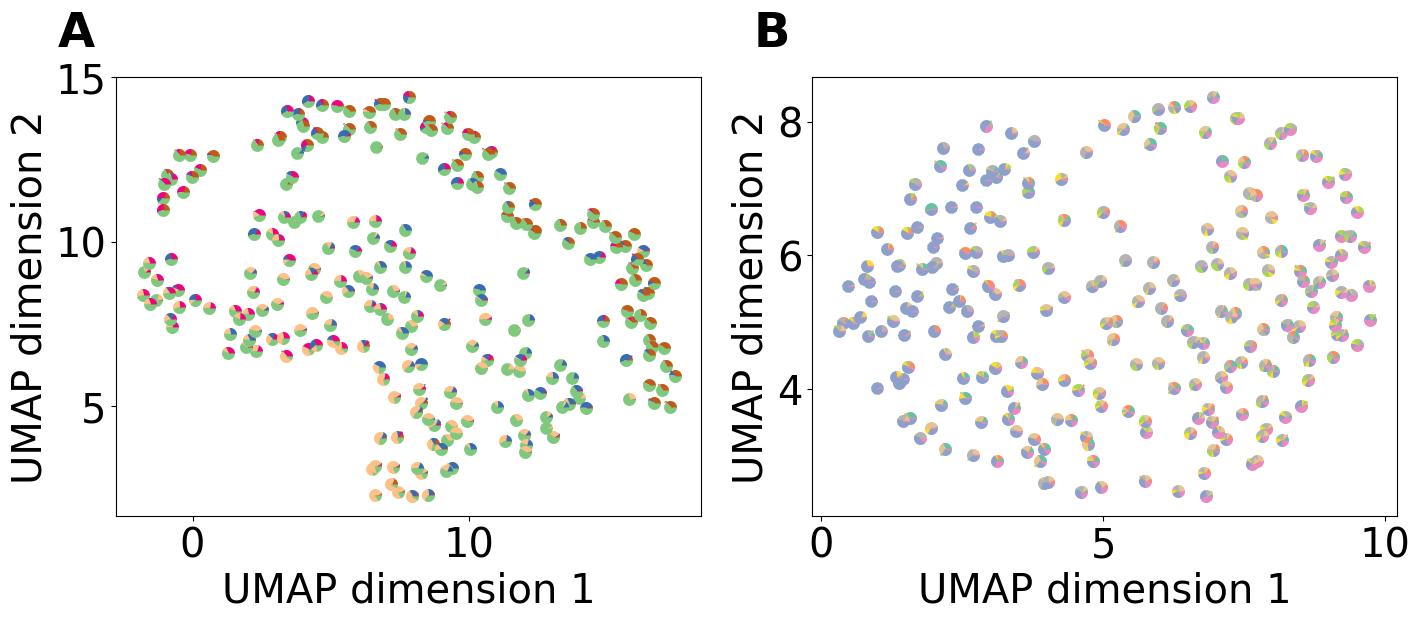

In [22]:
fig_width = 15
fig_height = 6.67

fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))
axE = axes[0]
axF = axes[1]

plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=70, ax=axE, fontsize=fs, palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=70, ax=axF, fontsize=fs, palette=oc_colors)

for ax, lbl in zip([axE, axF] , "AB"):
    add_label(ax, lbl)
    
plt.tight_layout()
fig_path = '../../paper/MultiPanel_latent_features_UMAP.png'
fig_dpi = 200
plt.savefig(fig_path, dpi=fig_dpi)

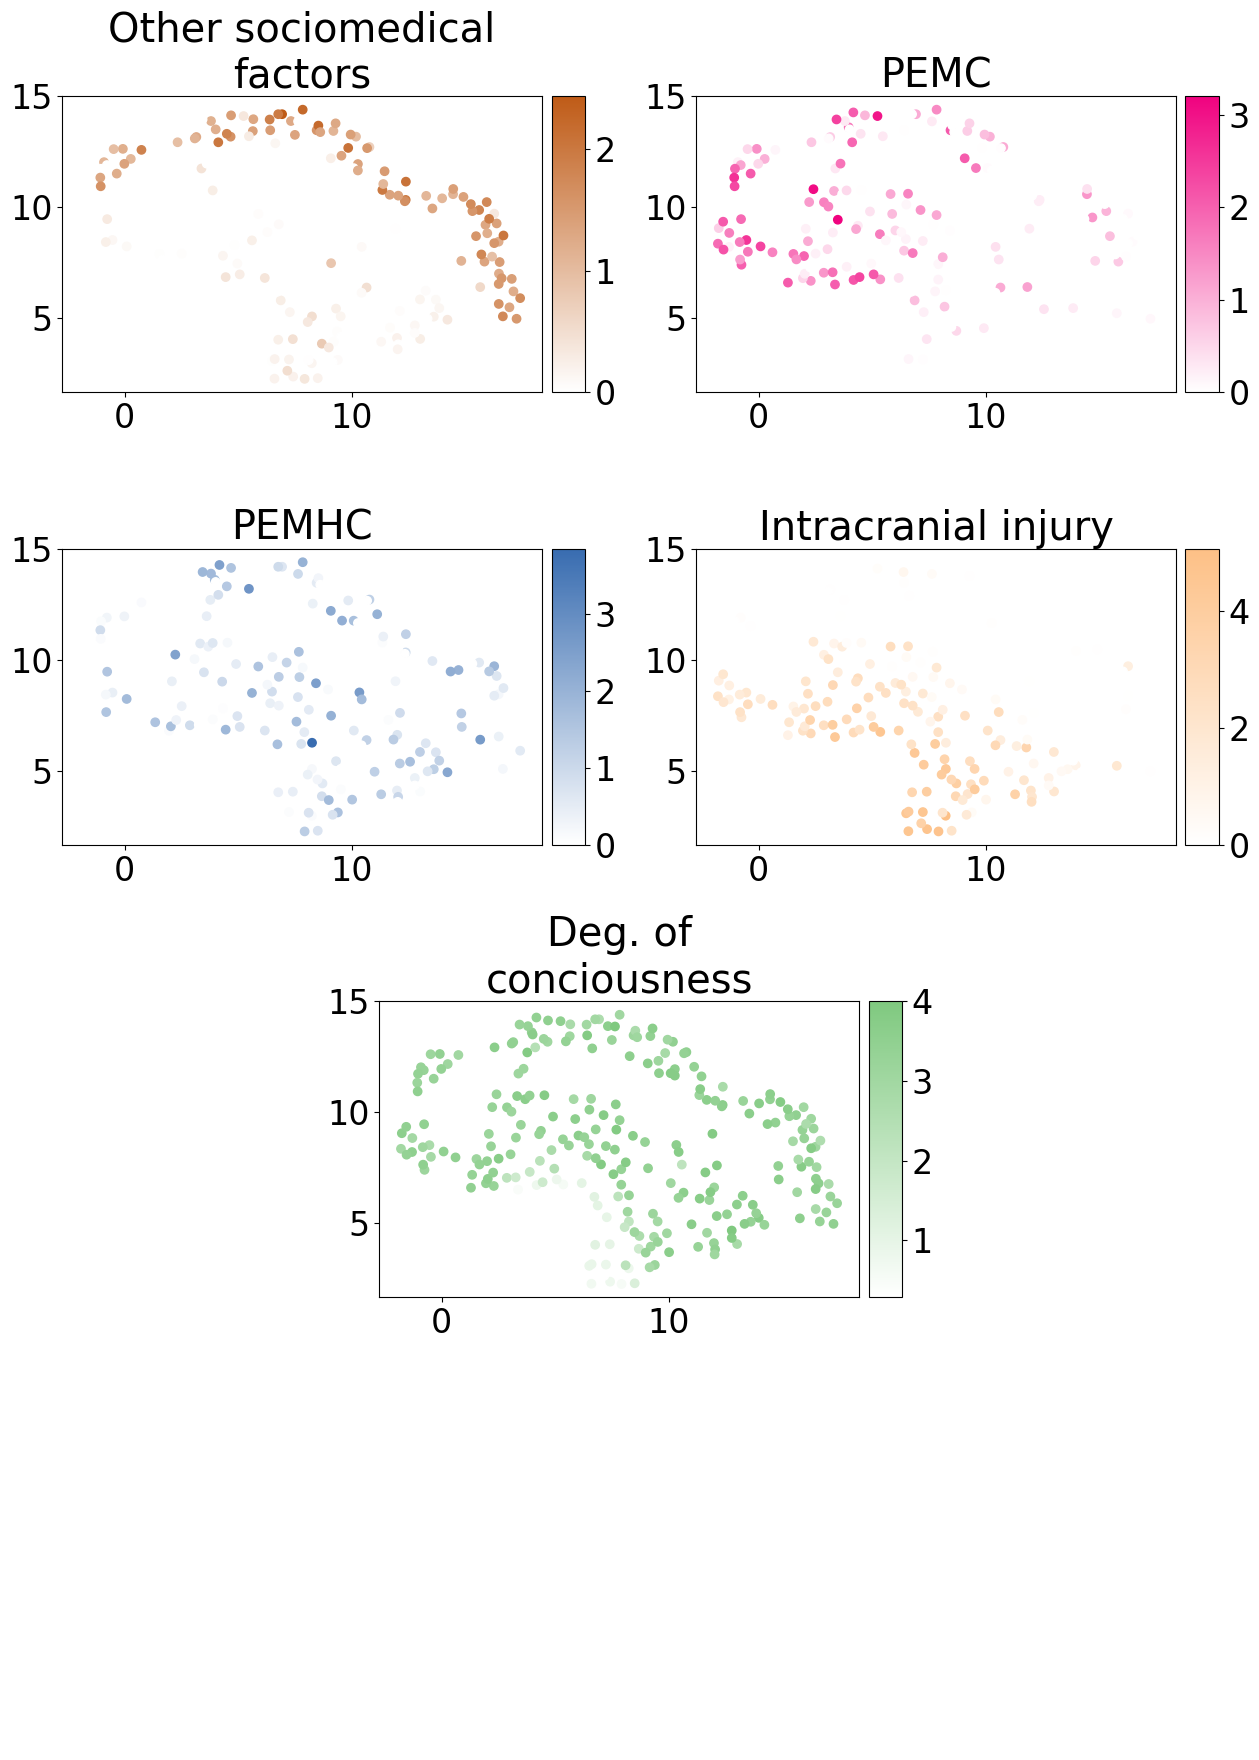

In [24]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')
cmaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in bm_colors]
plot_umap_nmf_weight(bm_emb, bm_weights, axes, bm_bases_labels, cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/biomarker_weights_umap.png', dpi=200)
plt.savefig('../../paper/biomarker_weights_umap.svg', dpi=200)

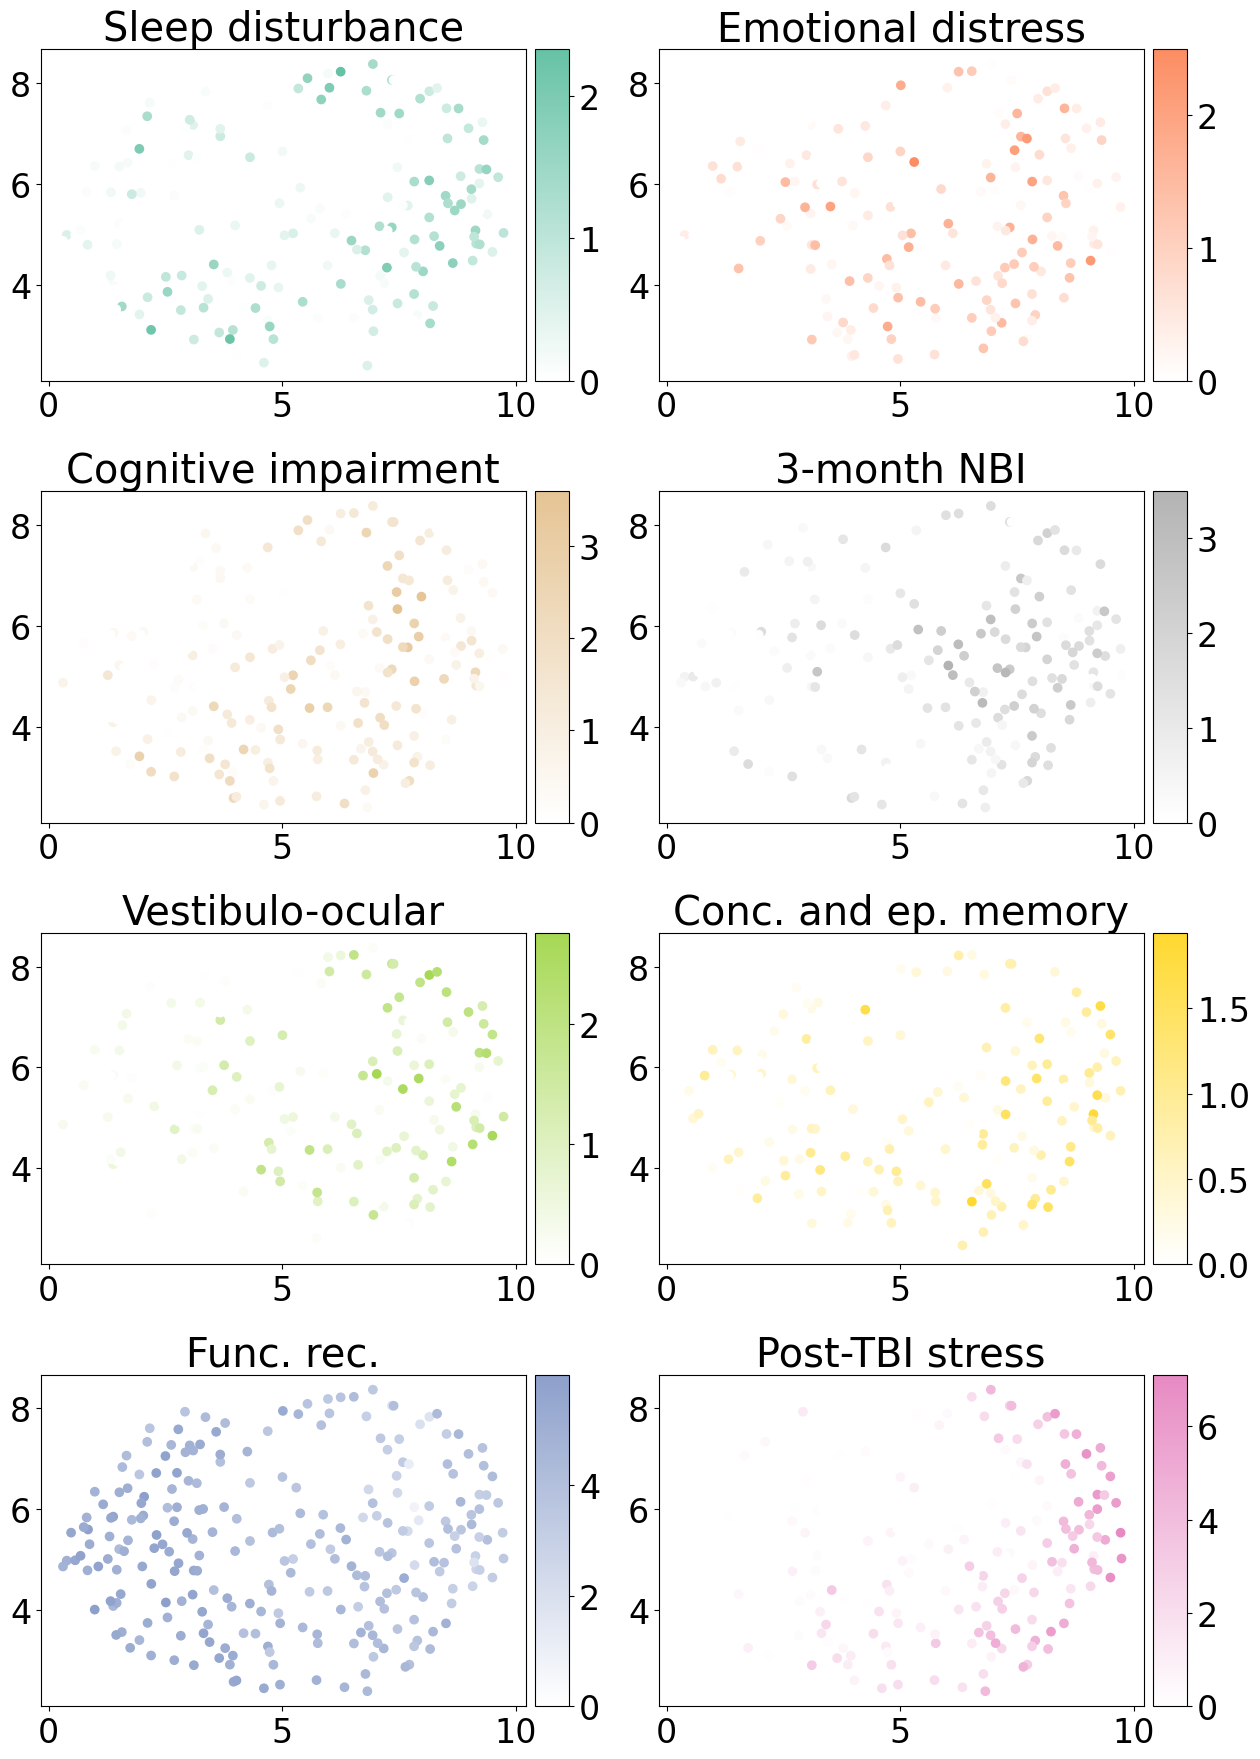

In [25]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

cmaps = colormaps = [mpc.LinearSegmentedColormap.from_list('mycmap', [(1.0,1.0,1.0), c]) for c in oc_colors]
plot_umap_nmf_weight(oc_emb, oc_weights, axes, [s.replace('\n', ' ') for s in oc_bases_labels], cmaps=cmaps)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap.png', dpi=200)
plt.savefig('../../paper/outcome_weights_umap.svg', dpi=200)

In [25]:
oc_bases_labels

array(['Sleep disturbance', 'Emotional distress', 'Cognitive impairment',
       '3-month NBI', 'Vestibulo-ocular', 'Conc. and\nep. memory',
       'Func. rec.', 'Post-TBI stress'], dtype='<U20')

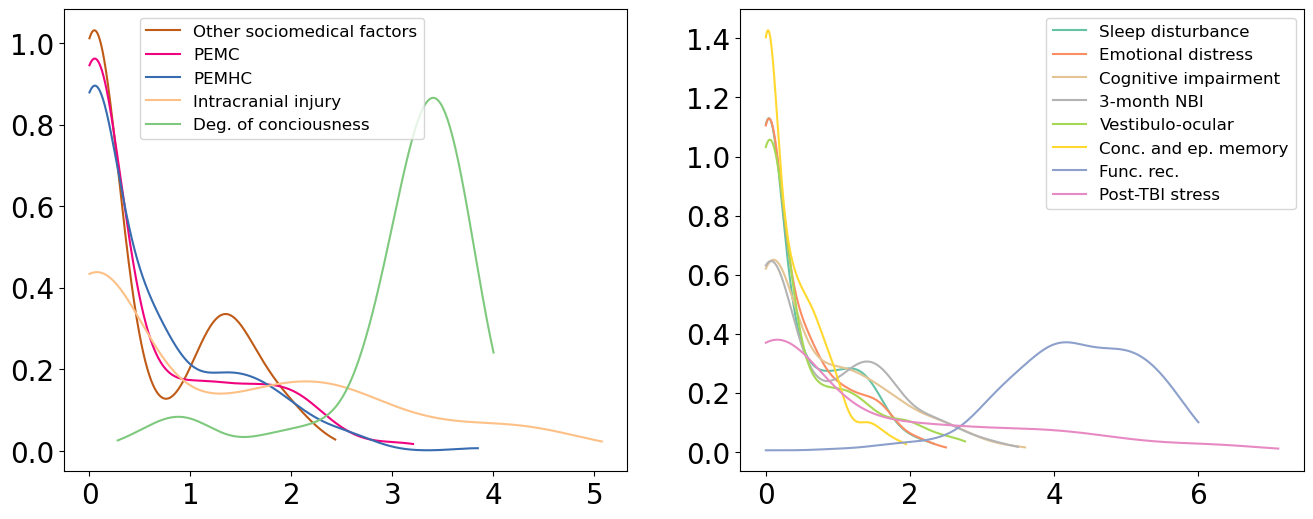

In [26]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(41)
fig, ax = plt.subplots(1, 2, figsize=(16,6))
def kde_hist(x, label, color=None, ax=None):
    if ax is None:
        ax = plt.gca()
    vals, bins = np.histogram(x, bins=10)
    kde = stats.gaussian_kde(x)
    xx = np.linspace(bins.min(), bins.max(), 1000)
    ax.plot(xx, kde(xx), label=label.replace('\n', ' '), c=color)

for i in range(bm_weights.shape[1]):
    kde_hist(bm_weights[:, i], bm_bases_labels[i], color=bm_colors[i], ax=ax[0])
ax[0].legend(fontsize=12, loc='upper left', bbox_to_anchor=(0.12, 1.0))

    
for i in range(oc_weights.shape[1]):
    kde_hist(oc_weights[:, i], oc_bases_labels[i], color=oc_colors[i], ax=ax[1])
ax[1].legend(fontsize=12)


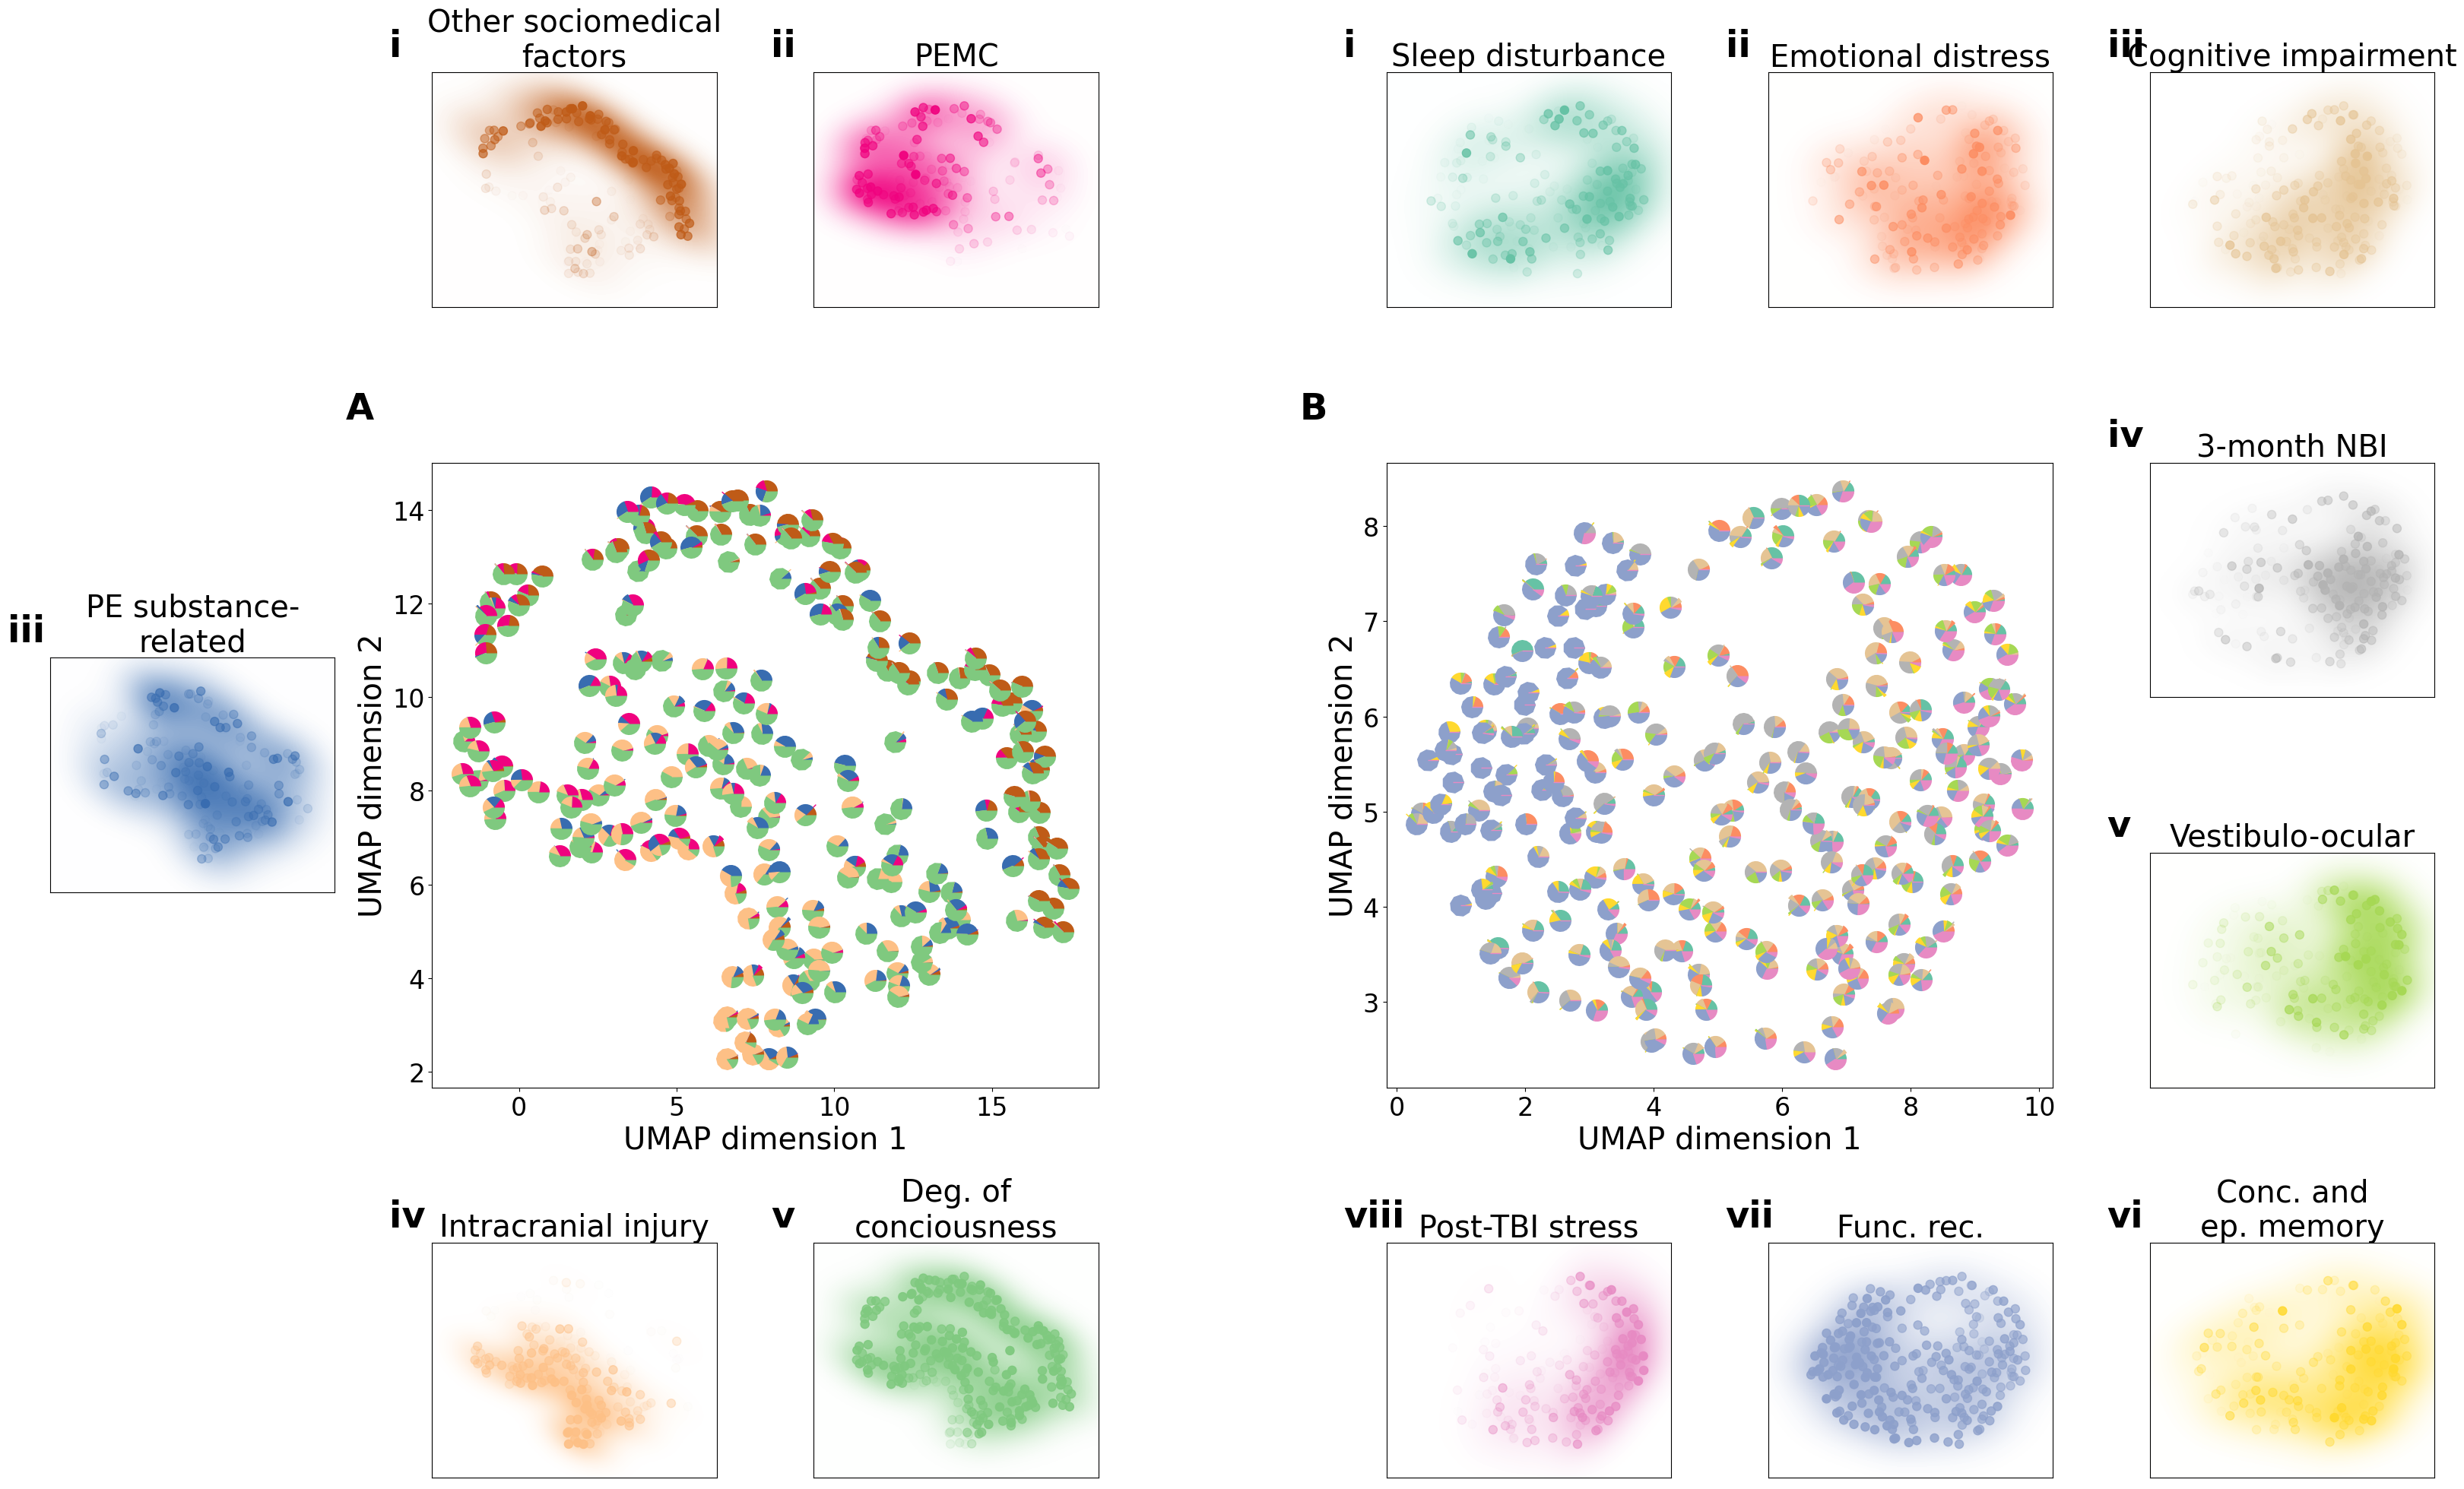

In [26]:
fig = plt.figure(figsize=(32.5, 20))
import matplotlib as mpl
orig_fontsize = mpl.rcParams['font.size']
mpl.rcParams['font.size'] = 20
gs = mgrid.GridSpec(8, 13, figure=fig)

def add_label(ax, label, x=-0.15, y=1.07, size='xx-large'):
    ax.text(x, y, label,  weight='bold', transform=ax.transAxes, size=size) 

ax_BmMain = fig.add_subplot(gs[2:-2, 2:6])
ax_OcMain = fig.add_subplot(gs[2:-2, 7:11])

axes = list()
axes.append(fig.add_subplot(gs[:2, 2:4]))
axes.append(fig.add_subplot(gs[:2, 4:6]))
axes.append(fig.add_subplot(gs[3:5, :2]))
axes.append(fig.add_subplot(gs[6:, 2:4]))
axes.append(fig.add_subplot(gs[6:, 4:6]))

axes.append(fig.add_subplot(gs[:2, 7:9]))
axes.append(fig.add_subplot(gs[:2, 9:11]))
axes.append(fig.add_subplot(gs[:2, 11:]))
axes.append(fig.add_subplot(gs[2:4, 11:]))
axes.append(fig.add_subplot(gs[4:6, 11:]))
axes.append(fig.add_subplot(gs[6:, 11:]))
axes.append(fig.add_subplot(gs[6:, 9:11]))
axes.append(fig.add_subplot(gs[6:, 7:9]))


sckw = {'s':64}

for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v'), axes[:5]):
    add_label(ax, lbl, size='xx-large')
    
for lbl, ax in zip(('i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii'), axes[5:]):
    add_label(ax, lbl, size='xx-large')
    

bm_labels = bm_bases_labels.copy()
bm_labels[2] = 'PE substance-\nrelated'

plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_labels, ax=axes[:5], scatter=True, cbar=False, scatter_kw=sckw)
plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=oc_bases_labels, ax=axes[5:], scatter=True, cbar=False, scatter_kw=sckw)


plot_umap_nmf_piechart(bm_weights/np.sum(bm_bases != 0, axis=1), bm_emb, s=400, ax=ax_BmMain, fontsize='x-large', palette=bm_colors)
plot_umap_nmf_piechart(oc_weights/np.sum(oc_bases != 0, axis=1), oc_emb, s=400, ax=ax_OcMain, fontsize='x-large', palette=oc_colors)

for lbl, ax in zip('AB', (ax_BmMain, ax_OcMain)):
    add_label(ax, lbl, size='xx-large', x=-0.13)
    ax.tick_params('both', labelsize='large')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_in_layout(False)
    
gs.tight_layout(fig)
plt.savefig('../../paper/umap_piecharts_kde.png', dpi=200)
plt.savefig('../../paper/umap_piecharts_kde.svg', dpi=200)
mpl.rcParams['font.size'] = orig_fontsize

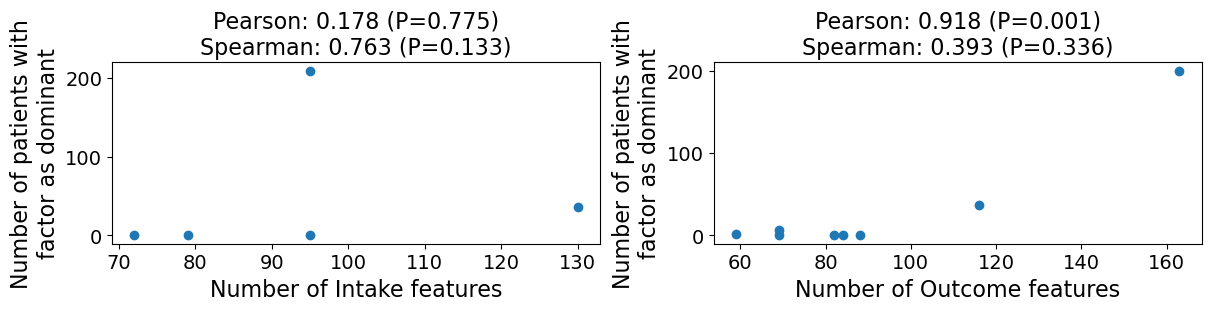

In [28]:
from scipy.stats import pearsonr, spearmanr

def dom_feat_corr(weights, bases, ax=None):
    if ax is None:
        ax = plt.gca()
    dom = np.bincount(np.argmax(weights, axis=1))
    n_feats = np.sum(bases != 0, axis=1)
    ax.scatter(n_feats, dom)
    p, p_p = pearsonr(n_feats, dom)
    s, s_p = spearmanr(n_feats, dom)
    ax.set_title(f'Pearson: {p:.3f} (P={p_p:.3f})\nSpearman: {s:.3f} (P={s_p:.3f})', fontsize=16)

fig, axes = plt.subplots(1, 2, figsize=(12, 3), constrained_layout=True)
dom_feat_corr(bm_weights, bm_bases, ax=axes[0])
dom_feat_corr(oc_weights, oc_bases, ax=axes[1])
axes[0].set_xlabel("Number of Intake features", fontsize=16)
axes[1].set_xlabel("Number of Outcome features", fontsize=16)
for ax in axes:
    ax.set_ylabel("Number of patients with\nfactor as dominant", fontsize=16)
    ax.tick_params('both', labelsize=14)
plt.savefig('../../paper/nmf_dom_feat_corr.png', dpi=100)

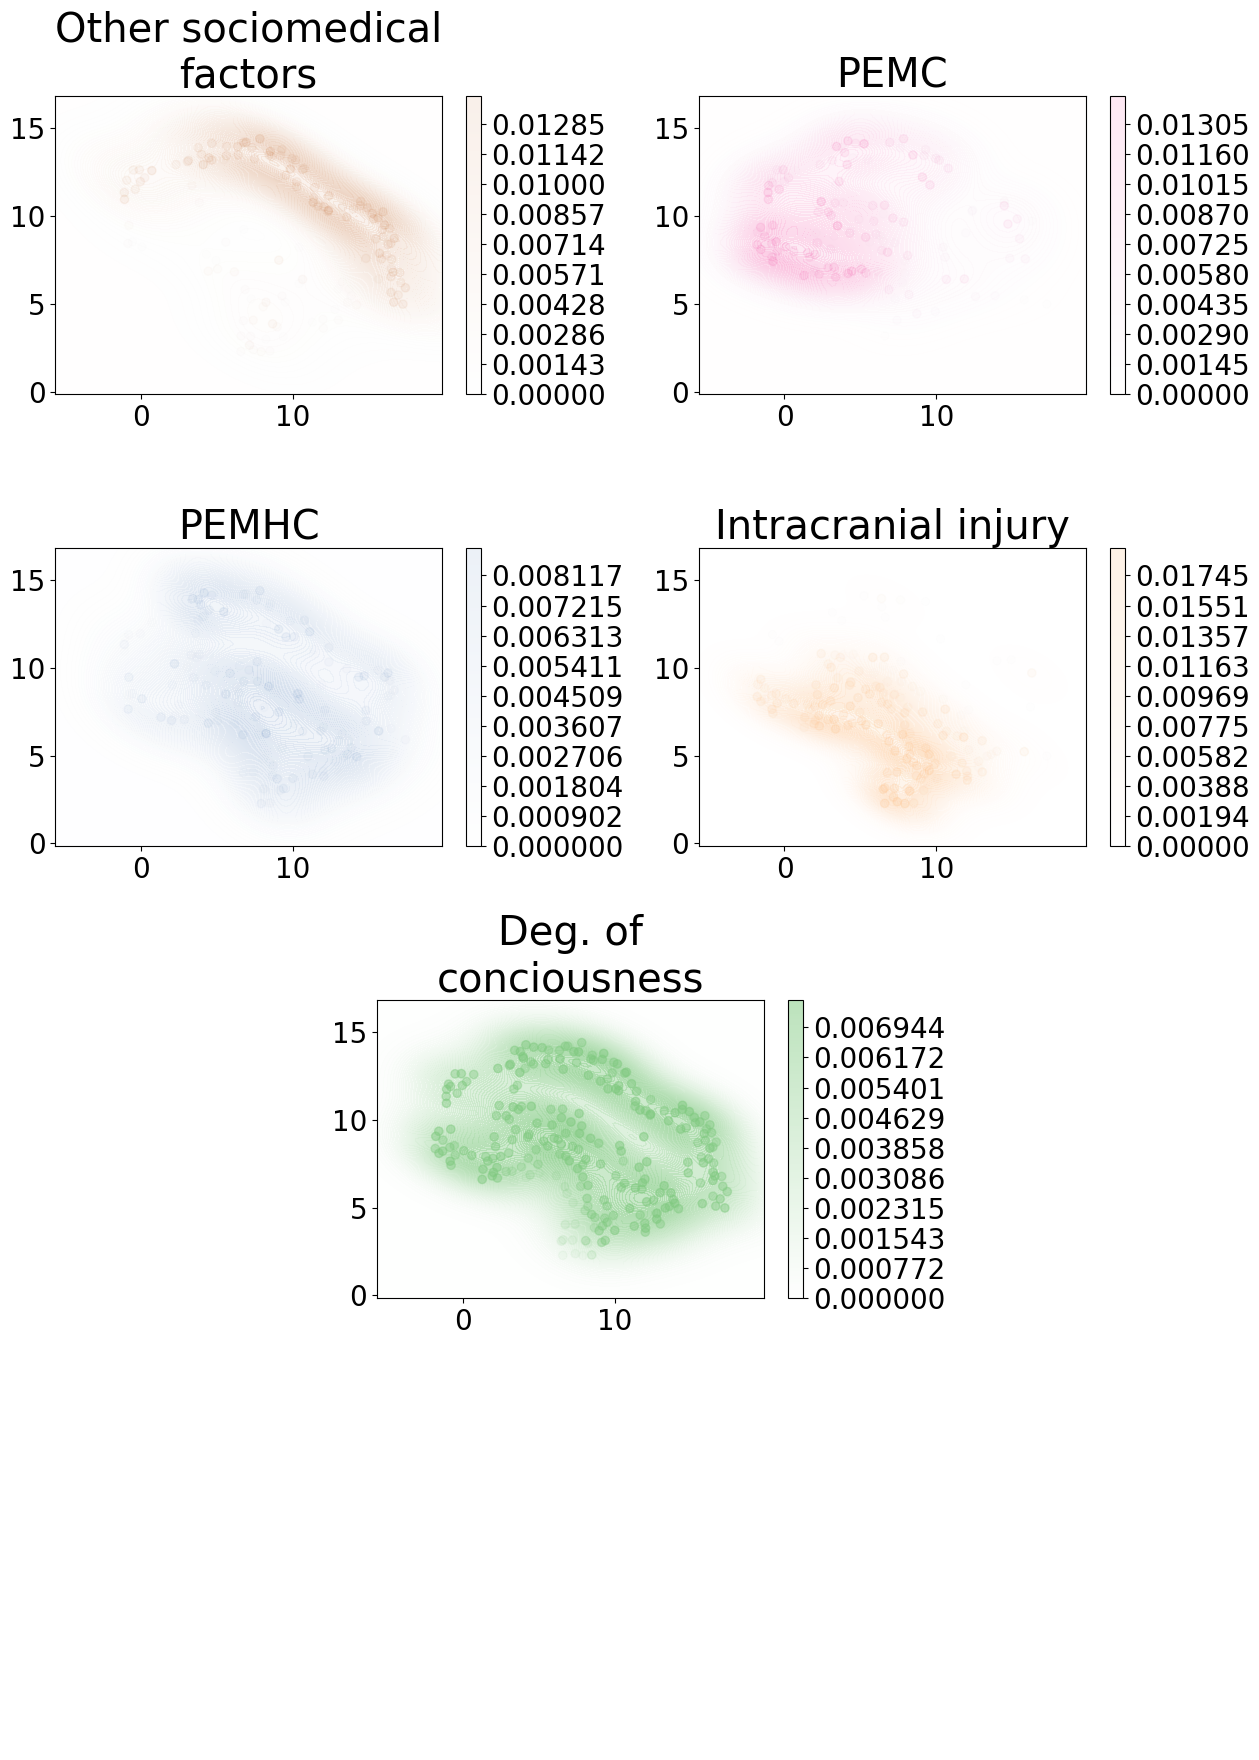

In [27]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(4):
    col = i%2
    axes.append(fig.add_subplot(gs[i//2, col*2:col*2+2]))
axes.append(fig.add_subplot(gs[2, 1:3]))
fig.add_subplot(gs[3, :]).axis('off')

plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_bases_labels, ax=axes, alpha=None, scatter=True)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde.png', dpi=200)
plt.savefig('../../paper/biomarker_weights_umap_kde.svg', dpi=200)

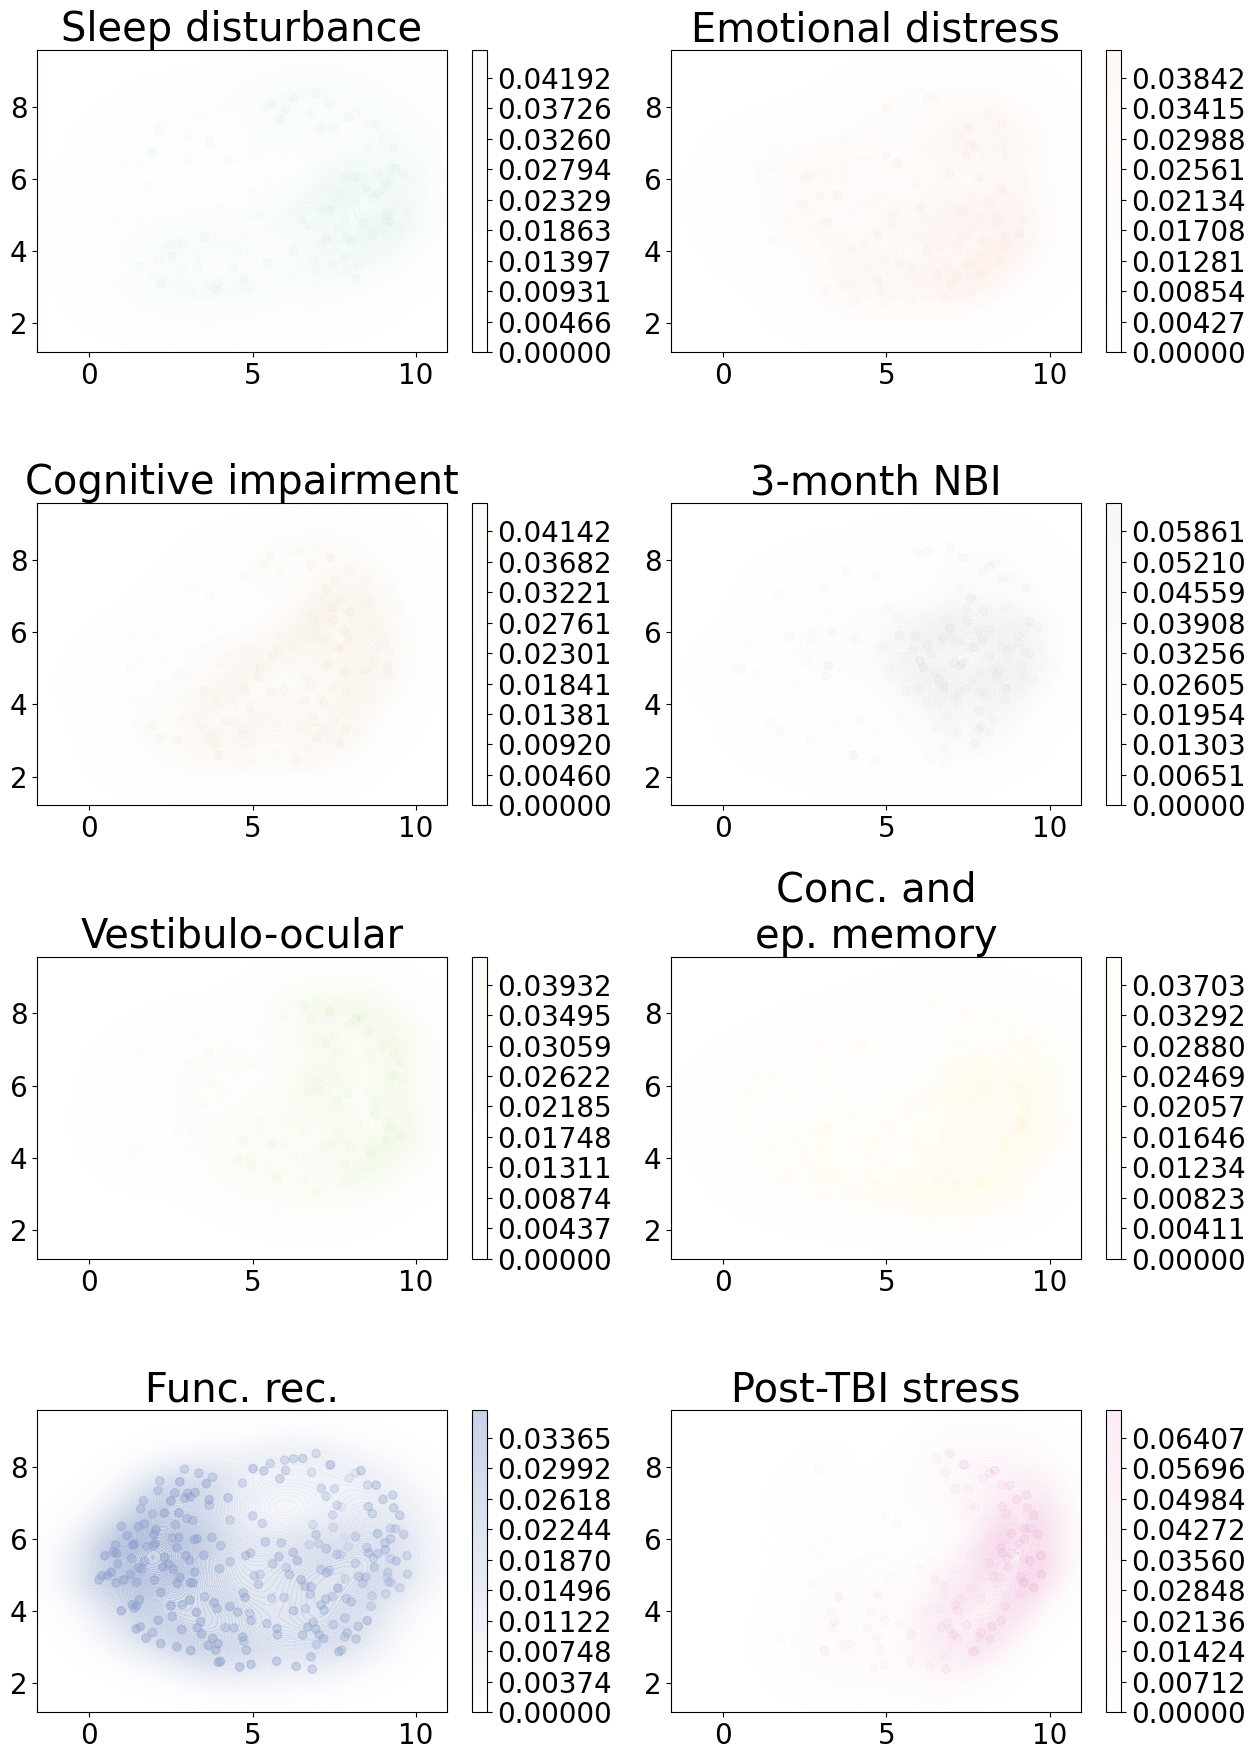

In [28]:
fig = plt.figure(figsize=(13, 18))
gs = mgrid.GridSpec(4, 4, figure=fig)
axes = list()
for i in range(8):
    col = i % 2
    row = i // 2
    axes.append(fig.add_subplot(gs[row, col*2:col*2+2]))

plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=[s for s in oc_bases_labels], ax=axes, alpha=None, scatter=True)
plt.tight_layout(h_pad=0.99, w_pad=0.9999)
plt.savefig('../../paper/outcome_weights_umap_kde.png', dpi=200)
plt.savefig('../../paper/outcome_weights_umap_kde.svg', dpi=200)

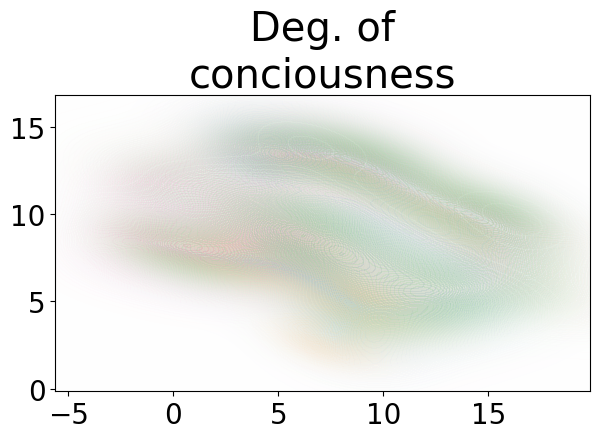

In [31]:
plot_umap_nmf_weight_kde(bm_emb, bm_weights, bm_colors, bases_labels=bm_bases_labels, alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/biomarker_weights_umap_kde_layered.png', dpi=200)

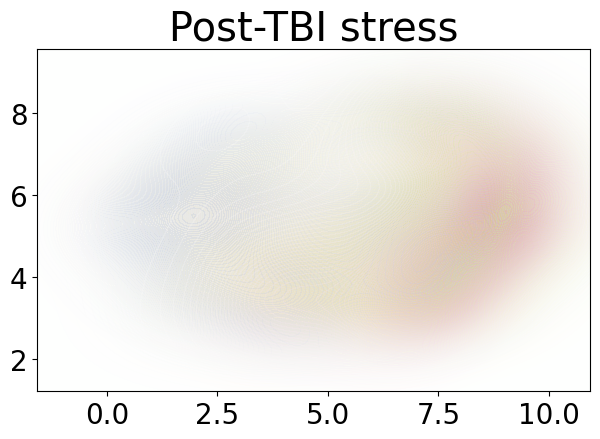

In [32]:
plot_umap_nmf_weight_kde(oc_emb, oc_weights, oc_colors, bases_labels=[s.replace('\n', ' ') for s in oc_bases_labels], alpha=0.2)
plt.tight_layout()
plt.savefig('../../paper/outcomes_weights_umap_kde_layered.png', dpi=200)

In [33]:
help("s".replace)

Help on built-in function replace:

replace(old, new, count=-1, /) method of builtins.str instance
    Return a copy with all occurrences of substring old replaced by new.
    
      count
        Maximum number of occurrences to replace.
        -1 (the default value) means replace all occurrences.
    
    If the optional argument count is given, only the first count occurrences are
    replaced.



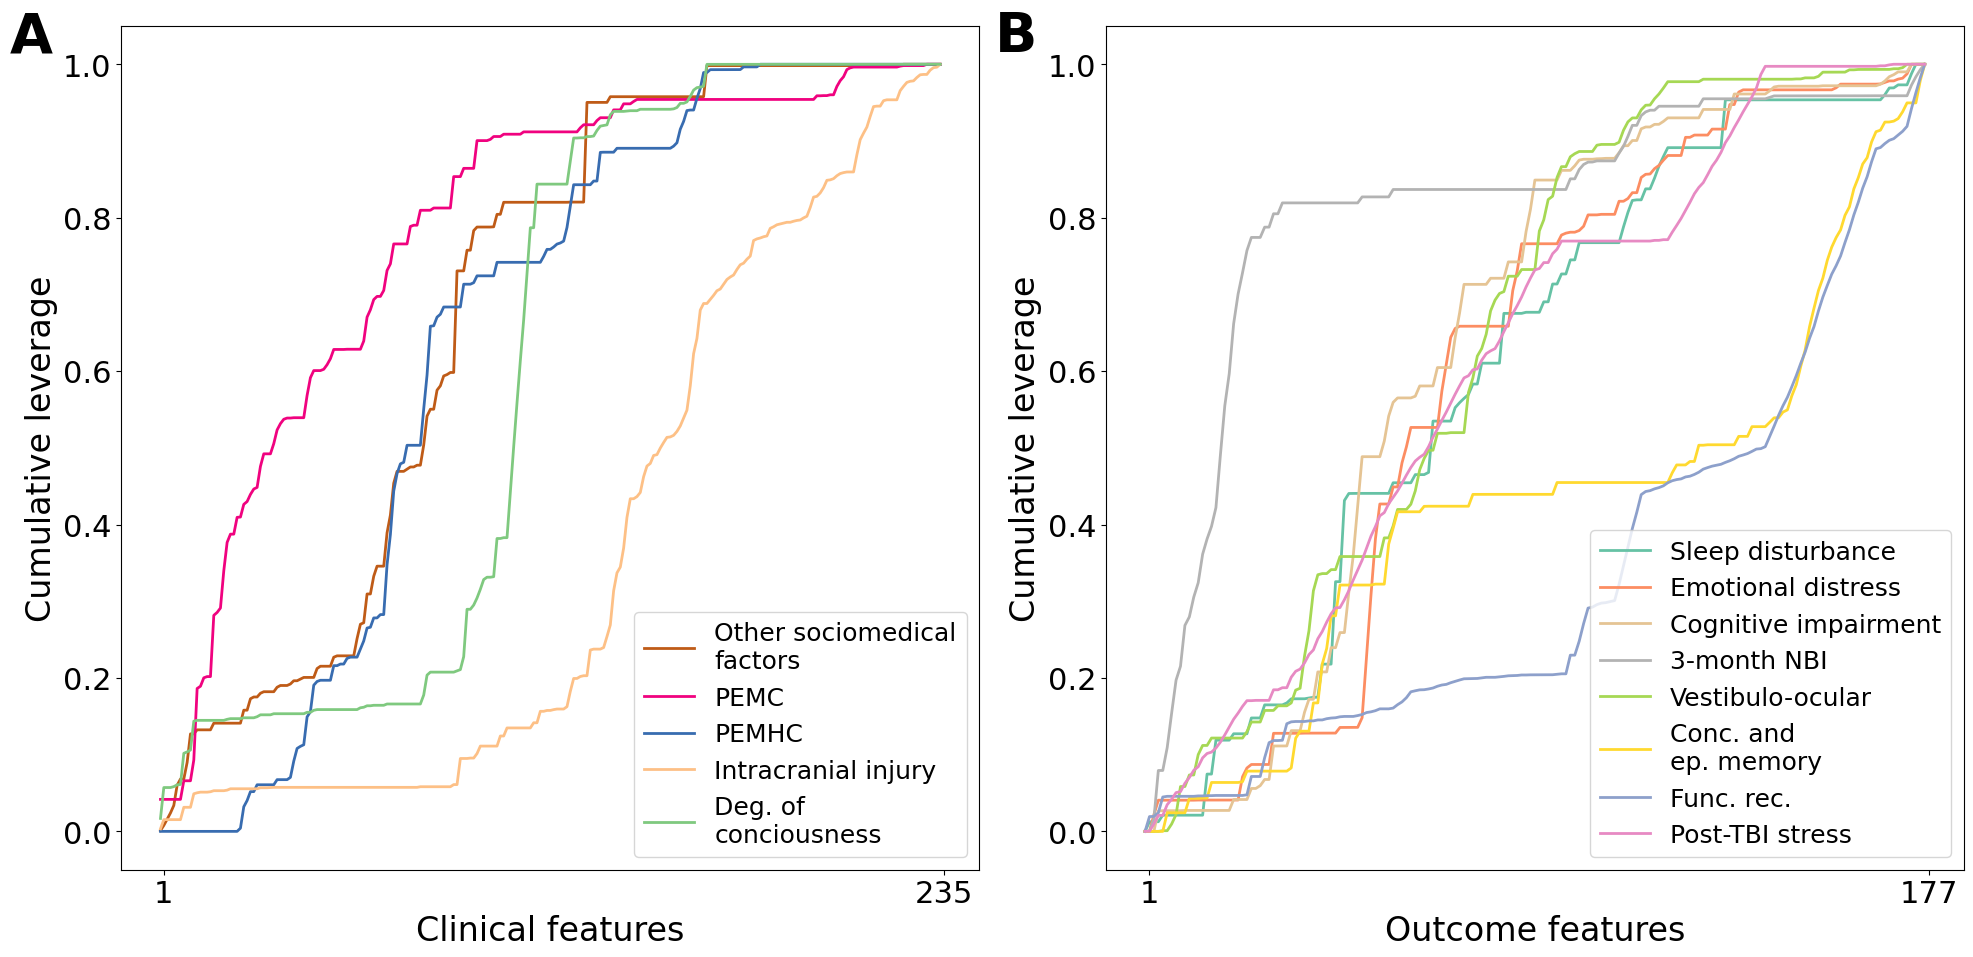

In [29]:
def plot_leverage(bases, colors, labels, ax):
    for i in range(len(labels)):
        x = np.cumsum(bases[i, :])
        x /= x[-1]
        ax.plot(x, color=colors[i], label=labels[i], lw=2)
    ax.legend(fontsize=18, loc='lower right')
    ax.tick_params('both', labelsize=22)
    ax.set_ylabel('Cumulative leverage', fontsize=24)
    xlabels = [1, bases.shape[1]]
    ax.set_xticks(xlabels, labels=xlabels)

fig, axes = plt.subplots(1, 2, figsize=(20,10))
plot_leverage(bm_bases, bm_colors, bm_bases_labels, axes[0])
axes[0].set_xlabel('Clinical features', fontsize=24)
plot_leverage(oc_bases, oc_colors, oc_bases_labels, axes[1])
axes[1].set_xlabel('Outcome features', fontsize=24)
for lbl, ax in zip('AB', axes):
    add_label(ax, lbl, x=-0.13, y=0.97, size=40)
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative.png', dpi=200)
plt.savefig('../../paper/bases_cumulative.svg', dpi=200)

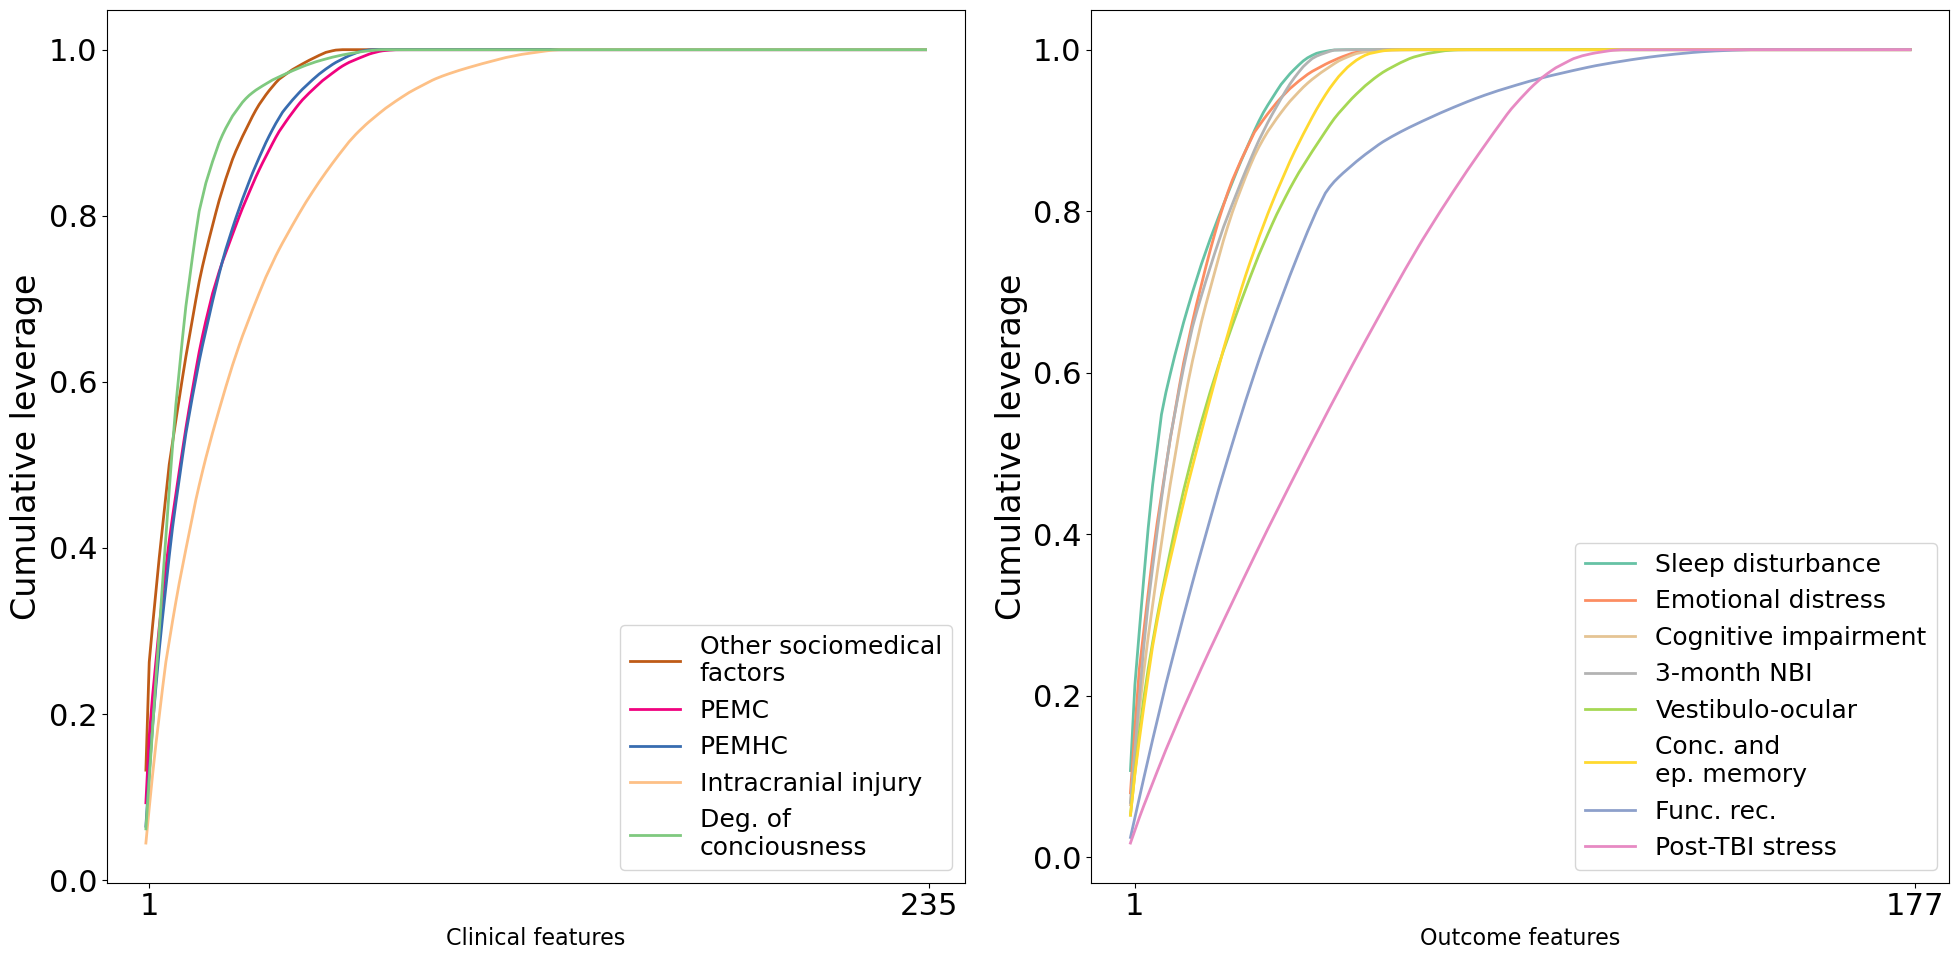

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
plot_leverage(np.sort(bm_bases, axis=1)[:, ::-1], bm_colors, bm_bases_labels, axes[0])
axes[0].set_xlabel('Clinical features', fontsize=16)
plot_leverage(np.sort(oc_bases, axis=1)[:, ::-1], oc_colors, oc_bases_labels, axes[1])
axes[1].set_xlabel('Outcome features', fontsize=16)
plt.tight_layout()
plt.savefig('../../paper/bases_cumulative_sorted.png', dpi=200)
plt.savefig('../../paper/bases_cumulative_sorted.svg', dpi=200)

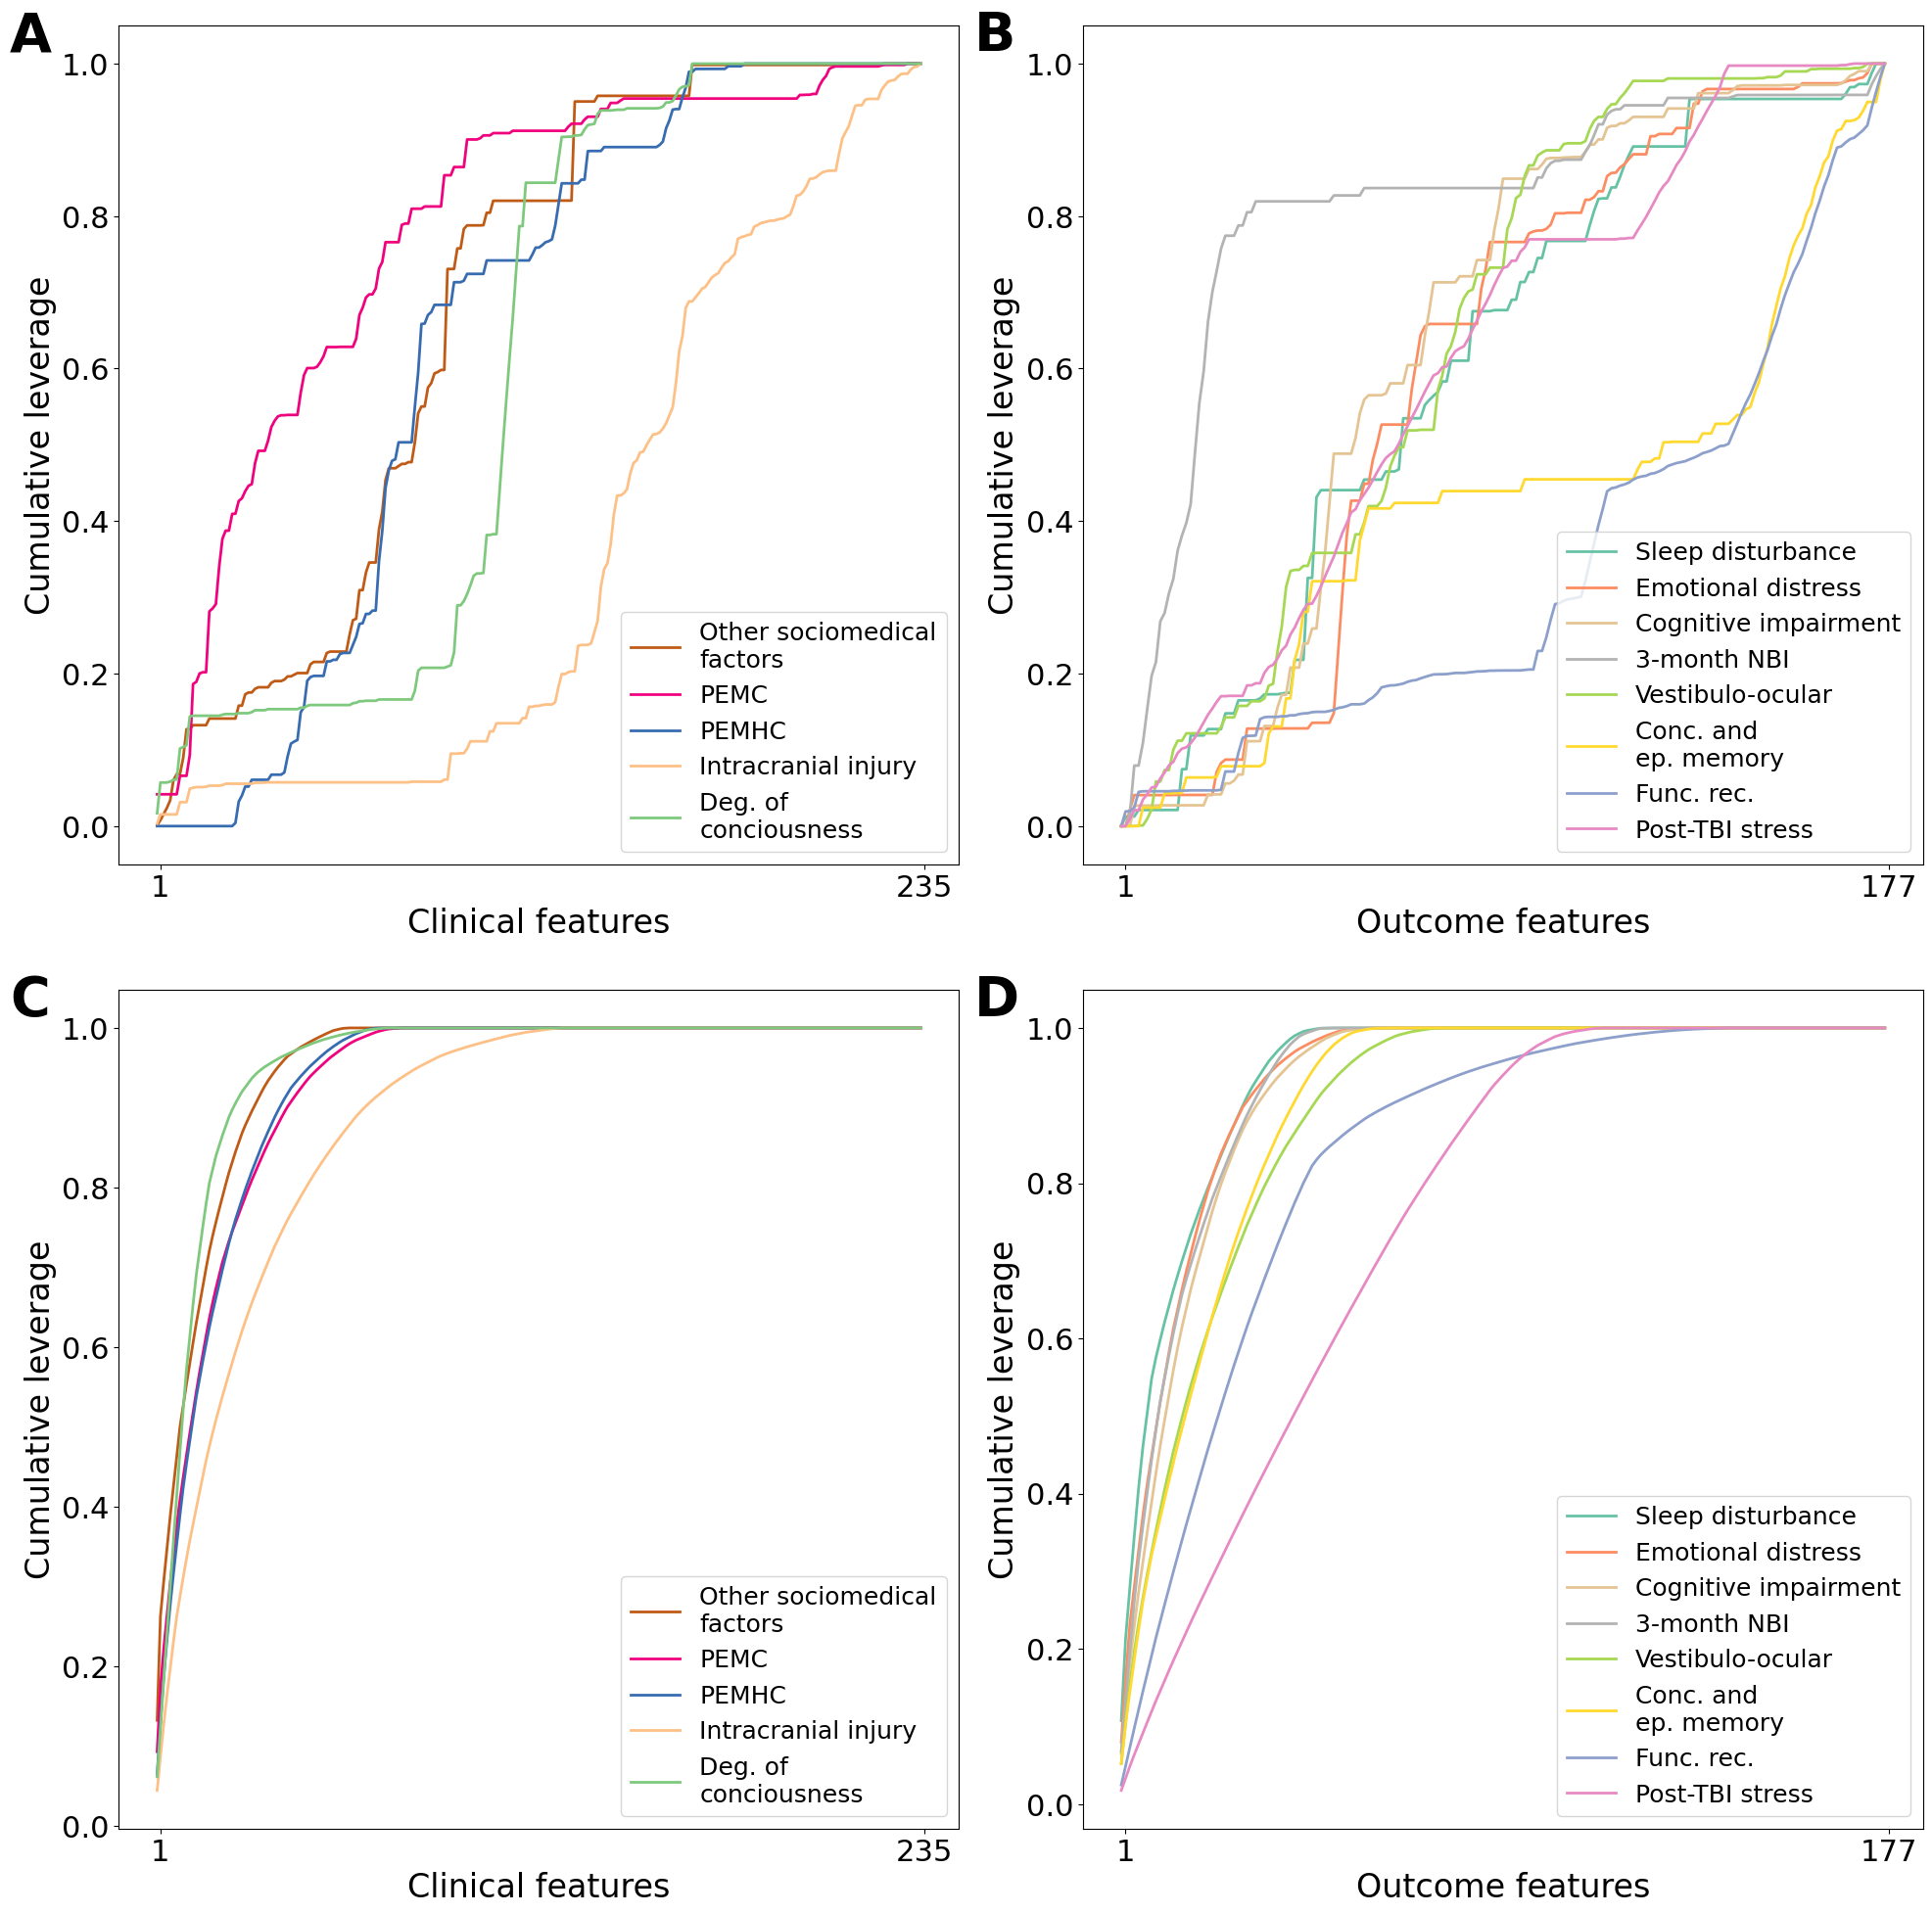

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20,20))

plot_leverage(bm_bases, bm_colors, bm_bases_labels, axes[0, 0])
axes[0, 0].set_xlabel('Clinical features', fontsize=24)
plot_leverage(oc_bases, oc_colors, oc_bases_labels, axes[0, 1])
axes[0, 1].set_xlabel('Outcome features', fontsize=24)

plot_leverage(np.sort(bm_bases, axis=1)[:, ::-1], bm_colors, bm_bases_labels, axes[1, 0])
axes[1, 0].set_xlabel('Clinical features', fontsize=24)
plot_leverage(np.sort(oc_bases, axis=1)[:, ::-1], oc_colors, oc_bases_labels, axes[1, 1])
axes[1, 1].set_xlabel('Outcome features', fontsize=24)

for lbl, ax in zip('ABCD', axes.ravel()):
    add_label(ax, lbl, x=-0.13, y=0.97, size=40)
plt.tight_layout()
plt.savefig('../../paper/bases_leverage.png', dpi=200)
plt.savefig('../../paper/bases_leverage.svg', dpi=200)